In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install neurite
%cd "/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration"
!ls

/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration
 affineRegNN2_debug.ipynb	    data
 affineRegNN3_data1_svd_rot.ipynb   generate_data2.m
 affineRegNN4.5_data_toy.ipynb	    layers.py
 affineRegNN4_data2.ipynb	    model_img
 affineRegNN5_data3.ipynb	    MRNet
 affineRegNN_archive.ipynb	    prototype.py
 affine_training_data_gen.ipynb     __pycache__
 baseline_DLIR_v2.png		    utils.py
 checkpoints			   'VoxelMorph Demo.ipynb'


In [3]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
# import scipy
import time
from tqdm.notebook import tqdm
import pickle
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import layers as custom_layers

In [4]:
# We renamed cusolver64_11.dll to cusolver64_10.dll to solve the compatibility issue.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Num GPUs Available:  1


## Load self-generated training data (by data loaders)

### Load dataloader

In [5]:
# trainDataPath = "./data/affineTrainingData2/affine{}.npz"
trainDataPath = "./data/affineTrainingData3/train/" #affine{}.npz
valDataPath = "./data/affineTrainingData3/val/"
testDataPath = "./data/affineTrainingData3/test/"
val_size = 300 # 650
test_size = 600
fixed_input_shape = (1, 64, 256, 256, 2)


train_path_list = os.listdir(trainDataPath)
train_path_list = [os.path.join(trainDataPath, item) for item in train_path_list]
val_path_list = os.listdir(valDataPath)
val_path_list = [os.path.join(valDataPath, item) for item in val_path_list]
val_path_list = val_path_list[:val_size]
test_path_list = os.listdir(testDataPath)
test_path_list = [os.path.join(testDataPath, item) for item in test_path_list]
test_path_list = test_path_list[:test_size]

## matlab path
# test_path_list = [
#     './data/affineTrainingData3/test/affine_0_0.npz',
#     './data/affineTrainingData3/test/affine_1_0.npz',
#     './data/affineTrainingData3/test/affine_2_0.npz',
#     './data/affineTrainingData3/test/affine_3_0.npz',
#     './data/affineTrainingData3/test/affine_4_0.npz']

# len(os.listdir(trainDataPath)), len(os.listdir(valDataPath)), len(os.listdir(testDataPath)) # (5000, 650, 600)
len(train_path_list), len(val_path_list), len(test_path_list)

(5000, 300, 600)

In [6]:
class msk_dataset:
    def __init__(self, input_path_list, batch_size:int, gt_trf_key="trf", train=True):
        assert batch_size > 0
        self.gt_trf_key = gt_trf_key
        self.input_path_list = input_path_list
        self.length = len(input_path_list)
        self.train = train

        print(f"Init dataset, trf key: {gt_trf_key}, len {self.length}")

        if gt_trf_key == "trf":
            dataset = tf.data.Dataset.from_generator(
                self.data_generator_for_trf, 
                output_signature=(tf.TensorSpec(shape=(64, 256, 256, 2), dtype=tf.float32),
                                  (tf.TensorSpec(shape=(64, 256, 256, 1), dtype=tf.float32),
                                   tf.TensorSpec(shape=(12), dtype=tf.float32))
                                 ),
                ) # args=(input_path_list,)
        elif gt_trf_key == "trf_21param":
            dataset = tf.data.Dataset.from_generator(
                self.data_generator_for_trf_21param, 
                output_signature=(tf.TensorSpec(shape=(64, 256, 256, 2), dtype=tf.float32),
                                  (tf.TensorSpec(shape=(64, 256, 256, 1), dtype=tf.float32),
                                   tf.TensorSpec(shape=(21), dtype=tf.float32))
                                 ))
        else:
            pass


        dataset = dataset.batch(batch_size, drop_remainder=False, num_parallel_calls=tf.data.AUTOTUNE, 
                                deterministic=False)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        self.dataset = dataset
        print(dataset.element_spec)
        
    def get_dataset(self):
        return self.dataset

    def data_generator_for_trf(self):
        """ The data loader for regular trf """
        ind_list = np.arange(self.length)
        while True:
            if self.train:
                ind_list = np.random.permutation(self.length)
            for i in ind_list:
                inputObj = np.load(self.input_path_list[i])
                fixedImg = inputObj["fixedImg"].astype("float32")
                movingImg = inputObj["movingImg"].astype("float32")
                imgPair = np.concatenate([movingImg, fixedImg], axis=4)
                tgtAffineTrf = inputObj["trf"].astype("float32")

                # print(imgPair.dtype, fixedImg.dtype, movingImg.dtype, tgtAffineTrf.dtype)
                # print(self.input_path_list[i])
                yield (imgPair[0], (fixedImg[0], tgtAffineTrf[0]))

    def data_generator_for_trf_21param(self):
        """ The data loader for trf_21param """
        ind_list = np.arange(self.length)
        while True:
            if self.train:
                ind_list = np.random.permutation(self.length)
            for i in ind_list:
                inputObj = np.load(self.input_path_list[i])
                fixedImg = inputObj["fixedImg"].astype("float32")
                movingImg = inputObj["movingImg"].astype("float32")
                imgPair = np.concatenate([movingImg, fixedImg], axis=4) 
                tgtAffineTrf = inputObj["trf_21param"].astype("float32") # [1, 21]
                
                yield (imgPair[0], (fixedImg[0], tgtAffineTrf[0]))

In [7]:
batch_size = 2
# train_dataset = msk_dataset(train_path_list, batch_size).get_dataset()
# val_dataset = msk_dataset(val_path_list, batch_size).get_dataset()
# test_dataset = msk_dataset(test_path_list, batch_size, train=False).get_dataset()

train_dataset = msk_dataset(train_path_list, batch_size, gt_trf_key="trf_21param").get_dataset()
val_dataset = msk_dataset(val_path_list, batch_size, gt_trf_key="trf_21param").get_dataset() # allow some randomness in val set
test_dataset = msk_dataset(test_path_list, batch_size, gt_trf_key="trf_21param", train=False).get_dataset()

Init dataset, trf key: trf_21param, len 5000
(TensorSpec(shape=(None, 64, 256, 256, 2), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 64, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None)))
Init dataset, trf key: trf_21param, len 300
(TensorSpec(shape=(None, 64, 256, 256, 2), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 64, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None)))
Init dataset, trf key: trf_21param, len 600
(TensorSpec(shape=(None, 64, 256, 256, 2), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 64, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None)))


In [ ]:
## check dataset
# c_dataset = msk_dataset(test_path_list, 4).get_dataset()
c_dataset = msk_dataset(test_path_list, 4, gt_trf_key="trf_21param").get_dataset()
ele = next(iter(c_dataset))
print(ele[0].shape, ele[0].dtype) 
print(ele[1][0].shape, ele[1][0].dtype, ele[1][1].shape, ele[1][1].dtype)

Init dataset, trf key: trf_21param, len 600
(TensorSpec(shape=(None, 64, 256, 256, 2), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 64, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None)))
(4, 64, 256, 256, 2) <dtype: 'float32'>
(4, 64, 256, 256, 1) <dtype: 'float32'> (4, 21) <dtype: 'float32'>


In [ ]:
# def data_generator(batchSize = 1, trainDataSize=1000):
#     assert batchSize > 0
#     if batchSize == 1:
#         while True:
#             idx = random.randrange(trainDataSize)
#             inputObj = np.load(trainDataPath.format(idx))
#             fixedImg = inputObj["fixedImg"]
#             movingImg = inputObj["movingImg"]
#             # movingImg = np.expand_dims(movingImg, axis=-1)
#             # movingImg = np.expand_dims(movingImg, axis=0)

#             # # pad
#             # depth = fixedImg.shape[1]
#             # up_pad = (fixed_depth-depth)//2
#             # down_pad = fixed_depth-depth - up_pad
#             # fixedImg = np.pad(fixedImg, pad_width=((0,0),(up_pad,down_pad),(0,0),(0,0),(0,0)), 
#             #                  mode="constant", constant_values=0)
#             # movingImg = np.pad(movingImg, pad_width=((0,0),(up_pad,down_pad),(0,0),(0,0),(0,0)), 
#             #                  mode="constant", constant_values=0)

#             imgPair = np.concatenate([movingImg, fixedImg], axis=4)
#             tgtAffineTrf = inputObj['trf']
#             tgtAffineTrf = np.expand_dims(tgtAffineTrf, axis=0)
            
#             yield (imgPair, [fixedImg, tgtAffineTrf])
#     else:
#         while True:
#             imgPairs = []
#             fixedImgs = []
#             tgtAffineTrfs = []
#             for _ in range(batchSize):
#                 idx = random.randrange(trainDataSize)
#                 inputObj = np.load(trainDataPath.format(idx))
#                 fixedImg = inputObj["fixedImg"]
#                 movingImg = inputObj["movingImg"]
#                 # movingImg = np.expand_dims(movingImg, axis=-1)
#                 # movingImg = np.expand_dims(movingImg, axis=0)

#                 # # pad
#                 # depth = fixedImg.shape[1]
#                 # up_pad = (fixed_depth-depth)//2
#                 # down_pad = fixed_depth-depth - up_pad
#                 # fixedImg = np.pad(fixedImg, pad_width=((0,0),(up_pad,down_pad),(0,0),(0,0),(0,0)), 
#                 #                 mode="constant", constant_values=0)
#                 # movingImg = np.pad(movingImg, pad_width=((0,0),(up_pad,down_pad),(0,0),(0,0),(0,0)), 
#                 #                 mode="constant", constant_values=0)

#                 imgPair = np.concatenate([movingImg, fixedImg], axis=4)
#                 tgtAffineTrf = inputObj['trf']
#                 tgtAffineTrf = np.expand_dims(tgtAffineTrf, axis=0)

#                 imgPairs.append(imgPair)
#                 fixedImgs.append(fixedImg)
#                 tgtAffineTrfs.append(tgtAffineTrf)
            
#             imgPairs = np.concatenate(imgPairs, axis=0)
#             fixedImgs = np.concatenate(fixedImgs, axis=0)
#             tgtAffineTrfs = np.concatenate(tgtAffineTrfs, axis=0)
#             yield (imgPairs, [fixedImgs, tgtAffineTrfs])

In [ ]:
### https://towardsdatascience.com/medical-image-dataloaders-in-tensorflow-2-x-ee5327a4398f
# # train_dataset = tf.data.Dataset.from_tensor_slices(train_path_list)
# # val_dataset = tf.data.Dataset.from_tensor_slices(val_path_list)
# # test_dataset = tf.data.Dataset.from_tensor_slices(test_path_list)
# # train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# class msk_dataset:
#     def __init__(self, input_path_list, batch_size:int, gt_trf_key="trf"):
#         assert batch_size > 0
#         self.gt_trf_key = gt_trf_key
#         # input_path_list = [[item] for item in input_path_list]
#         # dataset = tf.data.Dataset.from_tensor_slices(input_path_list)
#         dataset = tf.data.Dataset.from_tensor_slices(test_path_list)
#         print(dataset.element_spec)
#         # dataset = dataset.map(self.data_preprocessing, num_parallel_calls=tf.data.AUTOTUNE,
#         #                       deterministic=False)
#         # dataset = dataset.map(lambda x: tf.py_function(func=self.data_preprocessing, inp=[x], 
#         #                     out=tf.float32), 
#         #                       num_parallel_calls=tf.data.AUTOTUNE,
#         #                       deterministic=False)
#         dataset = dataset.map(lambda x: self.data_preprocessing(x), 
#                               num_parallel_calls=tf.data.AUTOTUNE,
#                               deterministic=False)
#         # dataset = dataset.batch(batch_size, drop_remainder=False, num_parallel_calls=tf.data.AUTOTUNE, 
#         #                         deterministic=False)
#         # dataset = dataset.prefetch(tf.data.AUTOTUNE)                           T
#         self.dataset = dataset
        
        
#     def get_dataset(self):
#         return self.dataset

#     @tf.function
#     def data_preprocessing(self, data_path):
#         print(data_path)
#         print(data_path.__dict__)
#         print(str(data_path))
#         inputObj = np.load(data_path)
#         fixedImg = inputObj["fixedImg"]
#         movingImg = inputObj["movingImg"]
#         imgPair = np.concatenate([movingImg, fixedImg], axis=4)
#         print(1)
#         tgtAffineTrf = inputObj[self.gt_trf_key]
#         return (imgPair, [fixedImg, tgtAffineTrf])

### Explore data

In [ ]:
for key, value in np.load(test_path_list[0], allow_pickle=True).items():
    print(key, "shape:", value.shape)

fixedImg shape: (1, 64, 256, 256, 1)
movingImg shape: (1, 64, 256, 256, 1)
trf shape: (1, 12)
trf_21param shape: (1, 21)


In [ ]:
dg = data_generator(4)
imgPairs, [fixedImgs, tgtAffineTrfs] = next(dg)
imgPairs.shape, fixedImgs.shape, tgtAffineTrfs.shape

((4, 64, 256, 256, 2), (4, 64, 256, 256, 1), (4, 12))

In [ ]:
# range 0~1
imgPairs.max()

1.0000001192092896

In [ ]:
## old data: mean mse img diff of 200 samples: 0.056
## new data: mean mse img diff of 500 samples: 0.03647
dg = data_generator()
# for x in dg:
#     break
# imgPair, [fixedImg, tgtAffineTrf] = x
# imgPair.shape # (1, 52, 256, 256, 2)

# ((imgPair[0,..., 0] - imgPair[0,..., 1])**2).mean()

count = 500
mean_mse = 0
for _ in tqdm(range(count)):
    imgPair, [fixedImg, tgtAffineTrf] = next(dg)
    diff = ((imgPair[0,..., 0] - imgPair[0,..., 1])**2).mean()
    mean_mse += diff
print(mean_mse/count)

  0%|          | 0/500 [00:00<?, ?it/s]

0.03647196479138947


In [ ]:
# check mean trf
def data_generator(batchSize = 1):
    # TODO: Batchify the funciton.
    for idx in range(2000):
        # idx = random.randrange(trainDataSize)
        inputObj = np.load(trainDataPath.format(idx))
        movingImg = inputObj['img']
        movingImg = np.expand_dims(movingImg, axis=-1)
        movingImg = np.expand_dims(movingImg, axis=0)
        imgPair = np.concatenate([movingImg, fixedImg], axis=4)

        tgtAffineTrf = inputObj['trf']
        tgtAffineTrf = np.expand_dims(tgtAffineTrf, axis=0)
        yield (imgPair, [fixedImg, tgtAffineTrf])

dataGen = data_generator()
trfs = []
for moving_test, (fixed, gt_trf) in tqdm(dataGen, total=2000):
    trfs.append(gt_trf)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
np.mean(trfs, axis=0)

array([[  1.00689002,   0.03654493,   0.03717216,  -3.63084558,
         -0.03239803,   0.99700621,  -0.10274288, -13.29430743,
         -0.0404979 ,   0.10132211,   0.9975384 , -16.55750802]])

## Train models

#### Baseline: direct affine matrix prediction

In [ ]:
## Modified model
## 1. use lrelu for all relu

# Change the channel dimension to get the image pair shape
# imgPairShape = list(fixedImg.shape)[1:]
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
moving_input = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
fixed_input = tf.expand_dims(inputs[:, :, :, :, 1], axis = -1)

down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
lrelu = layers.LeakyReLU(alpha=0.1)

conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation=lrelu)(moving_input)
print("conv_0: {}".format(conv_0.shape))
conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), activation=lrelu)(conv_0)
print("conv_1: {}".format(conv_1.shape))
filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
print("filtered_conv_1: {}".format(filtered_conv_1.shape))
conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation=lrelu)(filtered_conv_1)
print("conv_2: {}".format(conv_2.shape))
filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(conv_2)
print("filtered_conv_2: {}".format(filtered_conv_2.shape))
conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), activation=lrelu)(filtered_conv_2)
print("conv_3: {}".format(conv_3.shape))
conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation=lrelu)(conv_3)
print("conv_4: {}".format(conv_4.shape))

f_conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation=lrelu)(fixed_input)
f_conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), activation=lrelu)(f_conv_0)
f_filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(f_conv_1)
f_conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation=lrelu)(f_filtered_conv_1)
f_filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(f_conv_2)
f_conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), activation=lrelu)(f_filtered_conv_2)
f_conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation=lrelu)(f_conv_3)

concat_feats = tf.concat([conv_4, f_conv_4], axis = -1)
print(concat_feats.shape)

flattened = layers.Flatten()(concat_feats)
dense_0 = layers.Dense(1024, activation=lrelu)(flattened)
dense_1 = layers.Dense(256, activation=lrelu)(dense_0)
dense_2 = layers.Dense(64, activation=lrelu)(dense_1)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_2)


# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

conv_0: (None, 59, 113, 113, 4)
conv_1: (None, 54, 98, 98, 8)
filtered_conv_1: (None, 27, 49, 49, 8)
conv_2: (None, 22, 42, 42, 16)
filtered_conv_2: (None, 22, 21, 21, 16)
conv_3: (None, 19, 14, 14, 24)
conv_4: (None, 16, 11, 11, 32)
(None, 16, 11, 11, 64)
(None, 64, 256, 256, 1)


In [ ]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="baseline_model")
model.summary(line_length=150)

Model: "baseline_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 64, 256, 256, 2)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem_2 (SlicingOpLambda)     (None, 64, 256, 256)             0                 input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem_3 (SlicingOpLambda)     (None, 64, 256, 256) 

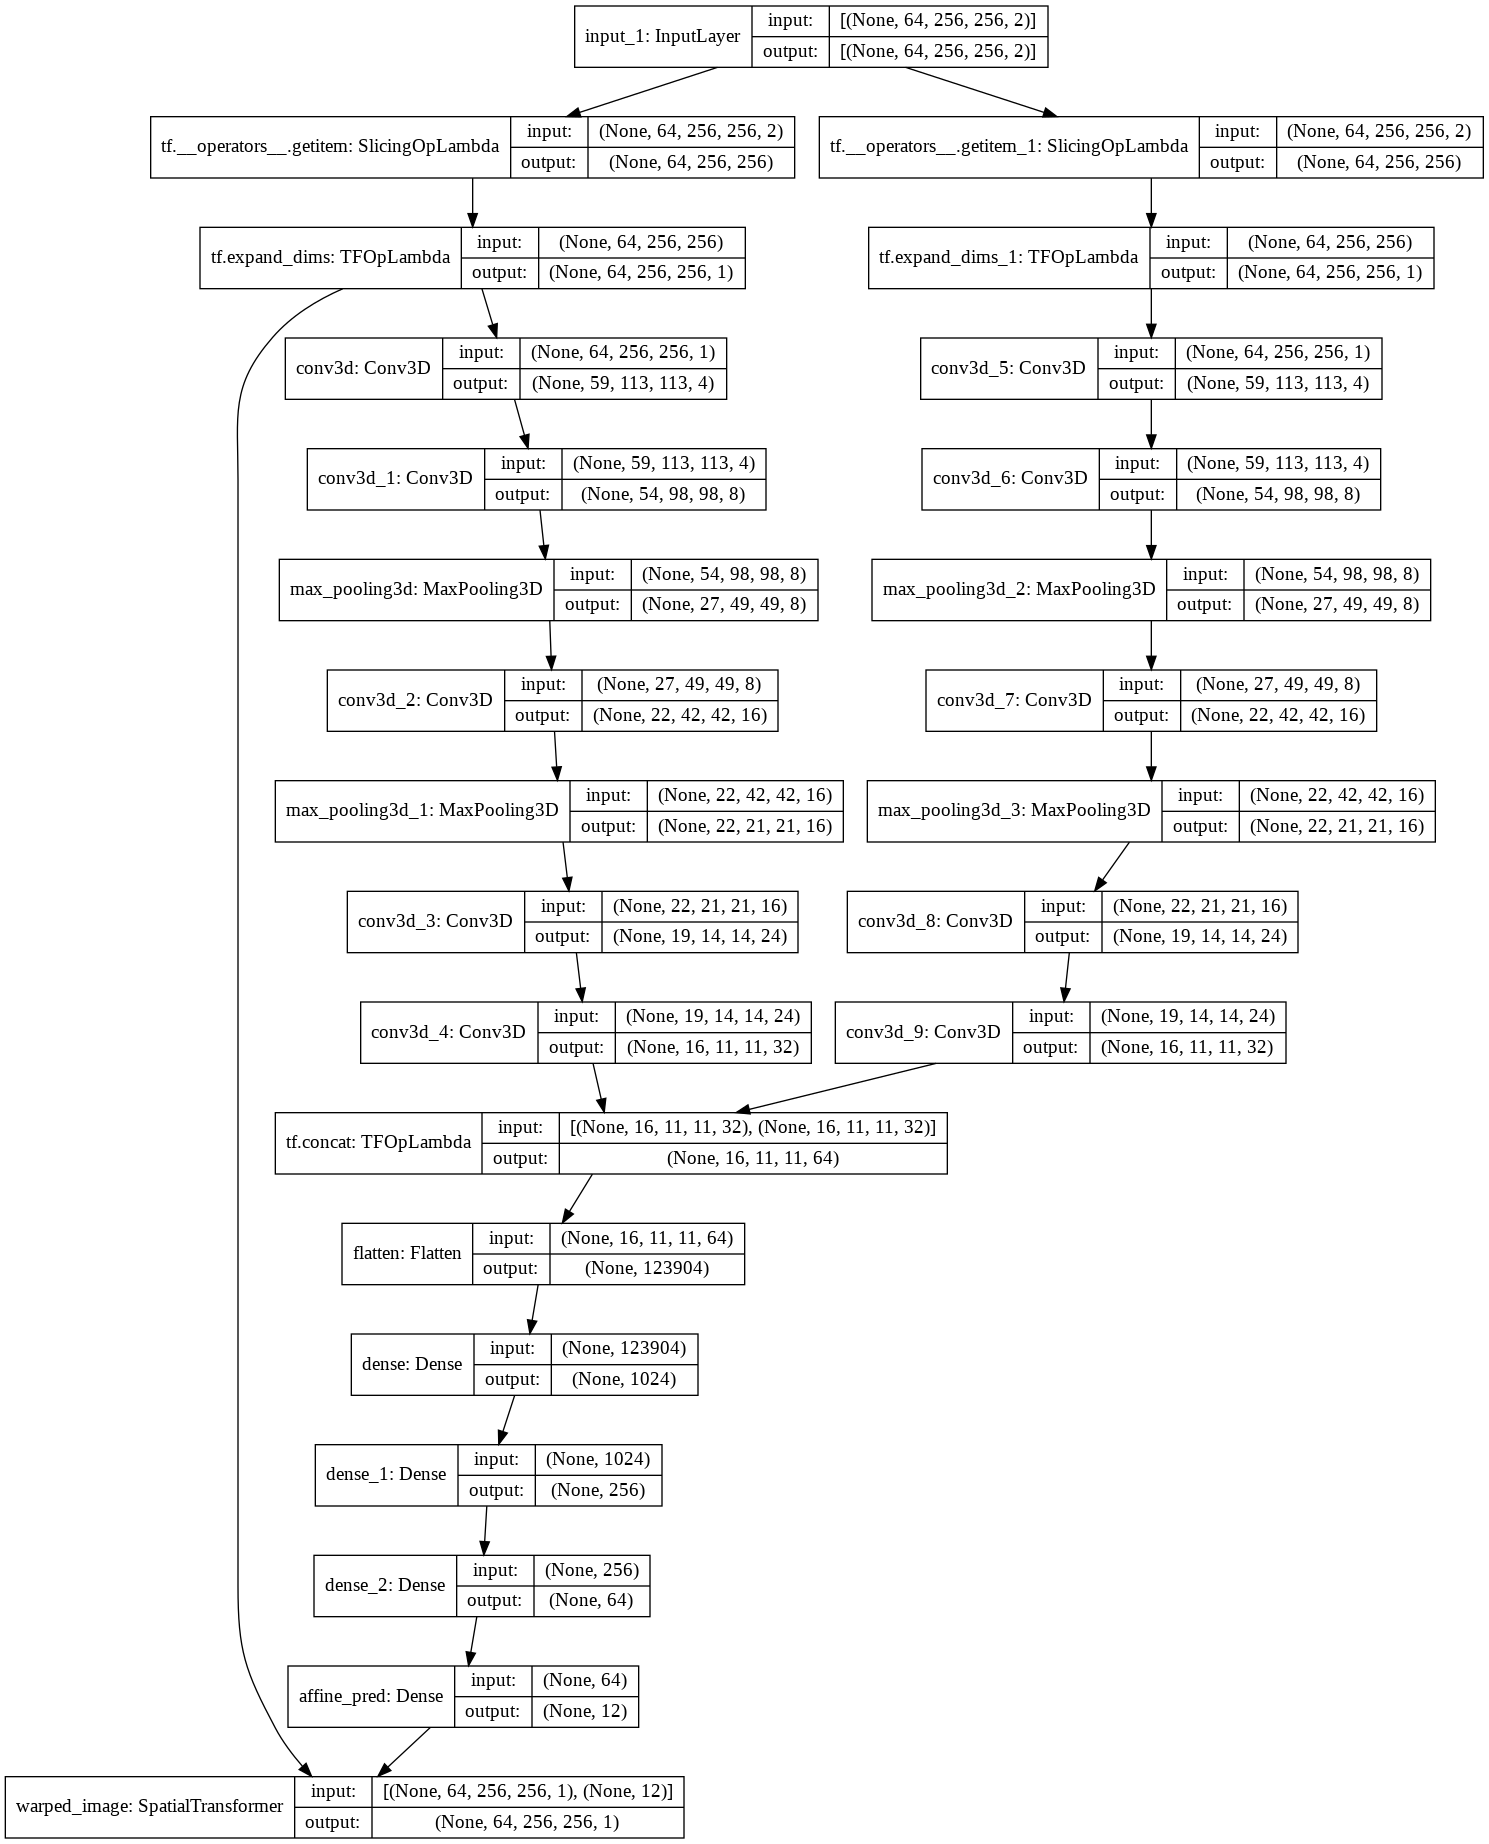

In [ ]:
keras.utils.plot_model(model, "test4.png", show_shapes=True)

#### New Baseline: direct affine matrix pred + DLIR style CNN

In [ ]:
## new baseline model
## 1. use lrelu for all relu
## 2. 5 layer of alternating 3x3x3 conv + 2/1x2x2 maxpool, the last pool is global average
##

# Change the channel dimension to get the image pair shape
# imgPairShape = list(fixedImg.shape)[1:]
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
# moving_input = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
# fixed_input = tf.expand_dims(inputs[:, :, :, :, 1], axis = -1)
moving_input, fixed_input = inputs[..., 0:1], inputs[..., 1:2]

# down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
down_depths = [16, 32, 64, 256, 512]
lrelu = layers.LeakyReLU(alpha=0.1)

# pipeline1
conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(moving_input)
print("conv_0: {}".format(conv_0.shape))
filtered_conv_0 = layers.MaxPool3D((2, 2, 2))(conv_0)

conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(filtered_conv_0)
print("conv_1: {}".format(conv_1.shape))
filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
print("filtered_conv_1: {}".format(filtered_conv_1.shape))

conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(filtered_conv_1)
print("conv_2: {}".format(conv_2.shape))
filtered_conv_2 = layers.MaxPool3D((2, 2, 2))(conv_2)
print("filtered_conv_2: {}".format(filtered_conv_2.shape))

conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(filtered_conv_2)
print("conv_3: {}".format(conv_3.shape))
filtered_conv_3 = layers.MaxPool3D((1, 2, 2))(conv_3)
print("conv_3: {}".format(conv_3.shape))

conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), 
                       padding='valid', activation=lrelu)(filtered_conv_3)
print("conv_4: {}".format(conv_4.shape))
global_ave_4 = layers.GlobalAveragePooling3D()(conv_4)

# pipeline 2
f_conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(fixed_input)
f_filtered_conv_0 = layers.MaxPool3D((2, 2, 2))(f_conv_0)
f_conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(f_filtered_conv_0)
f_filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(f_conv_1)
f_conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(f_filtered_conv_1)
f_filtered_conv_2 = layers.MaxPool3D((2, 2, 2))(f_conv_2)
f_conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(f_filtered_conv_2)
f_filtered_conv_3 = layers.MaxPool3D((1, 2, 2))(f_conv_3)
f_conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), 
                         padding='valid', activation=lrelu)(f_filtered_conv_3)
f_global_ave_4 = layers.GlobalAveragePooling3D()(f_conv_4)

concat_feats = tf.concat([global_ave_4, f_global_ave_4], axis = -1) # [B, C]
print(concat_feats.shape)

dense_0 = layers.Dense(1024, activation=lrelu)(concat_feats)
dense_1 = layers.Dense(128, activation=lrelu)(dense_0)
# dense_1 = layers.Dense(256, activation=lrelu)(dense_0)
# dense_2 = layers.Dense(64, activation=lrelu)(dense_1)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_1)


# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

conv_0: (None, 64, 256, 256, 16)
conv_1: (None, 32, 128, 128, 32)
filtered_conv_1: (None, 16, 64, 64, 32)
conv_2: (None, 16, 64, 64, 64)
filtered_conv_2: (None, 16, 32, 32, 64)
conv_3: (None, 16, 32, 32, 256)
conv_3: (None, 16, 32, 32, 256)
conv_4: (None, 14, 14, 14, 512)
(None, 1024)
(None, 64, 256, 256, 1)


In [ ]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="baseline_model")
model.summary(line_length=150)

Model: "baseline_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 64, 256, 256, 2)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem (SlicingOpLambda)       (None, 64, 256, 256, 1)          0                 input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem_1 (SlicingOpLambda)     (None, 64, 256, 256, 

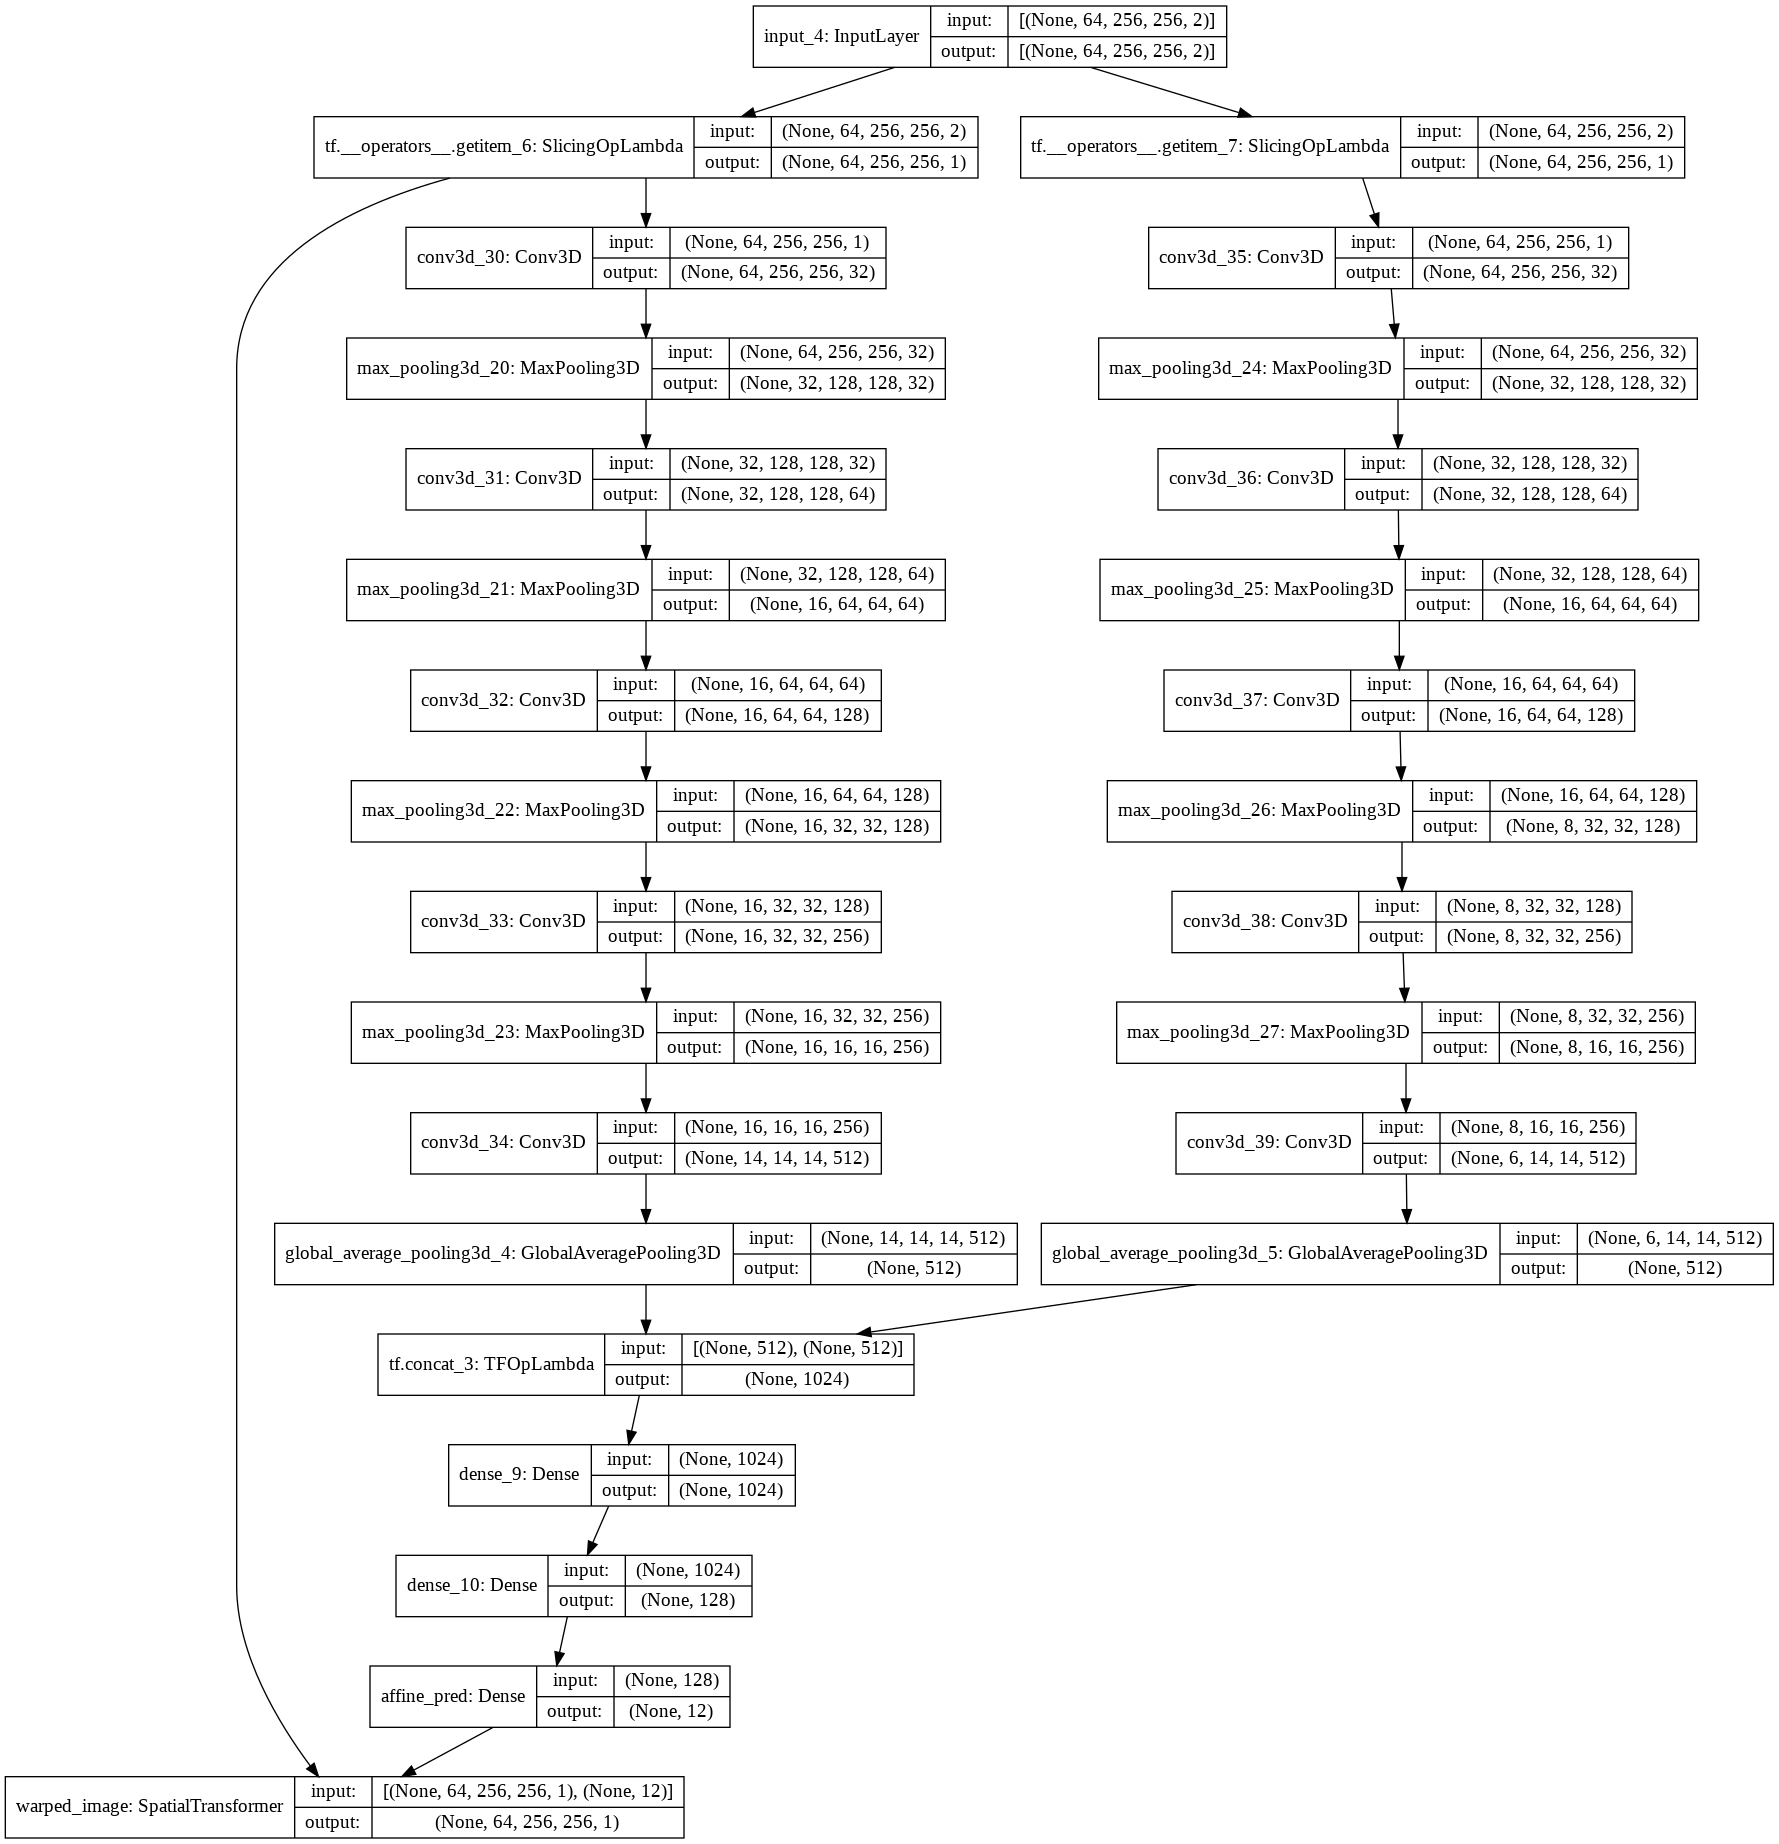

In [ ]:
keras.utils.plot_model(model, "baseline_DLIR.png", show_shapes=True)

##### new baseline model v2

In [ ]:
## new baseline model
## 1. use lrelu for all relu
## 2. 5 layer of alternating 3x3x3 conv + 2/1x2x2 maxpool, the last pool is global average
##

# Change the channel dimension to get the image pair shape
# imgPairShape = list(fixedImg.shape)[1:]
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
# moving_input = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
# fixed_input = tf.expand_dims(inputs[:, :, :, :, 1], axis = -1)
moving_input, fixed_input = inputs[..., 0:1], inputs[..., 1:2]

# down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
# down_depths = [16, 32, 64, 256, 512]# v1
# down_depths = [32, 64, 128, 512, 1024]
down_depths = [16, 32, 128, 512, 512]
lrelu = layers.LeakyReLU(alpha=0.1)

# pipeline1
conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(moving_input)
print("conv_0: {}".format(conv_0.shape))
filtered_conv_0 = layers.MaxPool3D((2, 2, 2))(conv_0)

conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(filtered_conv_0)
print("conv_1: {}".format(conv_1.shape))
filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
print("filtered_conv_1: {}".format(filtered_conv_1.shape))

conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(filtered_conv_1)
print("conv_2: {}".format(conv_2.shape))
filtered_conv_2 = layers.MaxPool3D((2, 2, 2))(conv_2)
print("filtered_conv_2: {}".format(filtered_conv_2.shape))

conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), 
                       padding='same', activation=lrelu)(filtered_conv_2)
print("conv_3: {}".format(conv_3.shape))
filtered_conv_3 = layers.MaxPool3D((1, 2, 2))(conv_3)
print("conv_3: {}".format(conv_3.shape))

conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), 
                       padding='valid', activation=lrelu)(filtered_conv_3)
print("conv_4: {}".format(conv_4.shape))
global_ave_4 = layers.GlobalAveragePooling3D()(conv_4)

# pipeline 2
f_conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(fixed_input)
f_filtered_conv_0 = layers.MaxPool3D((2, 2, 2))(f_conv_0)
f_conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(f_filtered_conv_0)
f_filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(f_conv_1)
f_conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(f_filtered_conv_1)
f_filtered_conv_2 = layers.MaxPool3D((2, 2, 2))(f_conv_2)
f_conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), 
                         padding='same', activation=lrelu)(f_filtered_conv_2)
f_filtered_conv_3 = layers.MaxPool3D((1, 2, 2))(f_conv_3)
f_conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), 
                         padding='valid', activation=lrelu)(f_filtered_conv_3)
f_global_ave_4 = layers.GlobalAveragePooling3D()(f_conv_4)

concat_feats = tf.concat([global_ave_4, f_global_ave_4], axis = -1) # [B, C]
print(concat_feats.shape)

dense_0 = layers.Dense(1024, activation=lrelu)(concat_feats)
dense_1 = layers.Dense(256, activation=lrelu)(dense_0)
dense_2 = layers.Dense(64, activation=lrelu)(dense_1)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_2)


# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="baseline_model")
model.summary(line_length=150)

conv_0: (None, 64, 256, 256, 16)
conv_1: (None, 32, 128, 128, 32)
filtered_conv_1: (None, 16, 64, 64, 32)
conv_2: (None, 16, 64, 64, 128)
filtered_conv_2: (None, 8, 32, 32, 128)
conv_3: (None, 8, 32, 32, 512)
conv_3: (None, 8, 32, 32, 512)
conv_4: (None, 6, 14, 14, 512)
(None, 1024)
(None, 64, 256, 256, 1)
Model: "baseline_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_3 (InputLayer)                             [(None, 64, 256, 256, 2)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem_3 (SlicingOpLambda)     (None, 64, 256,

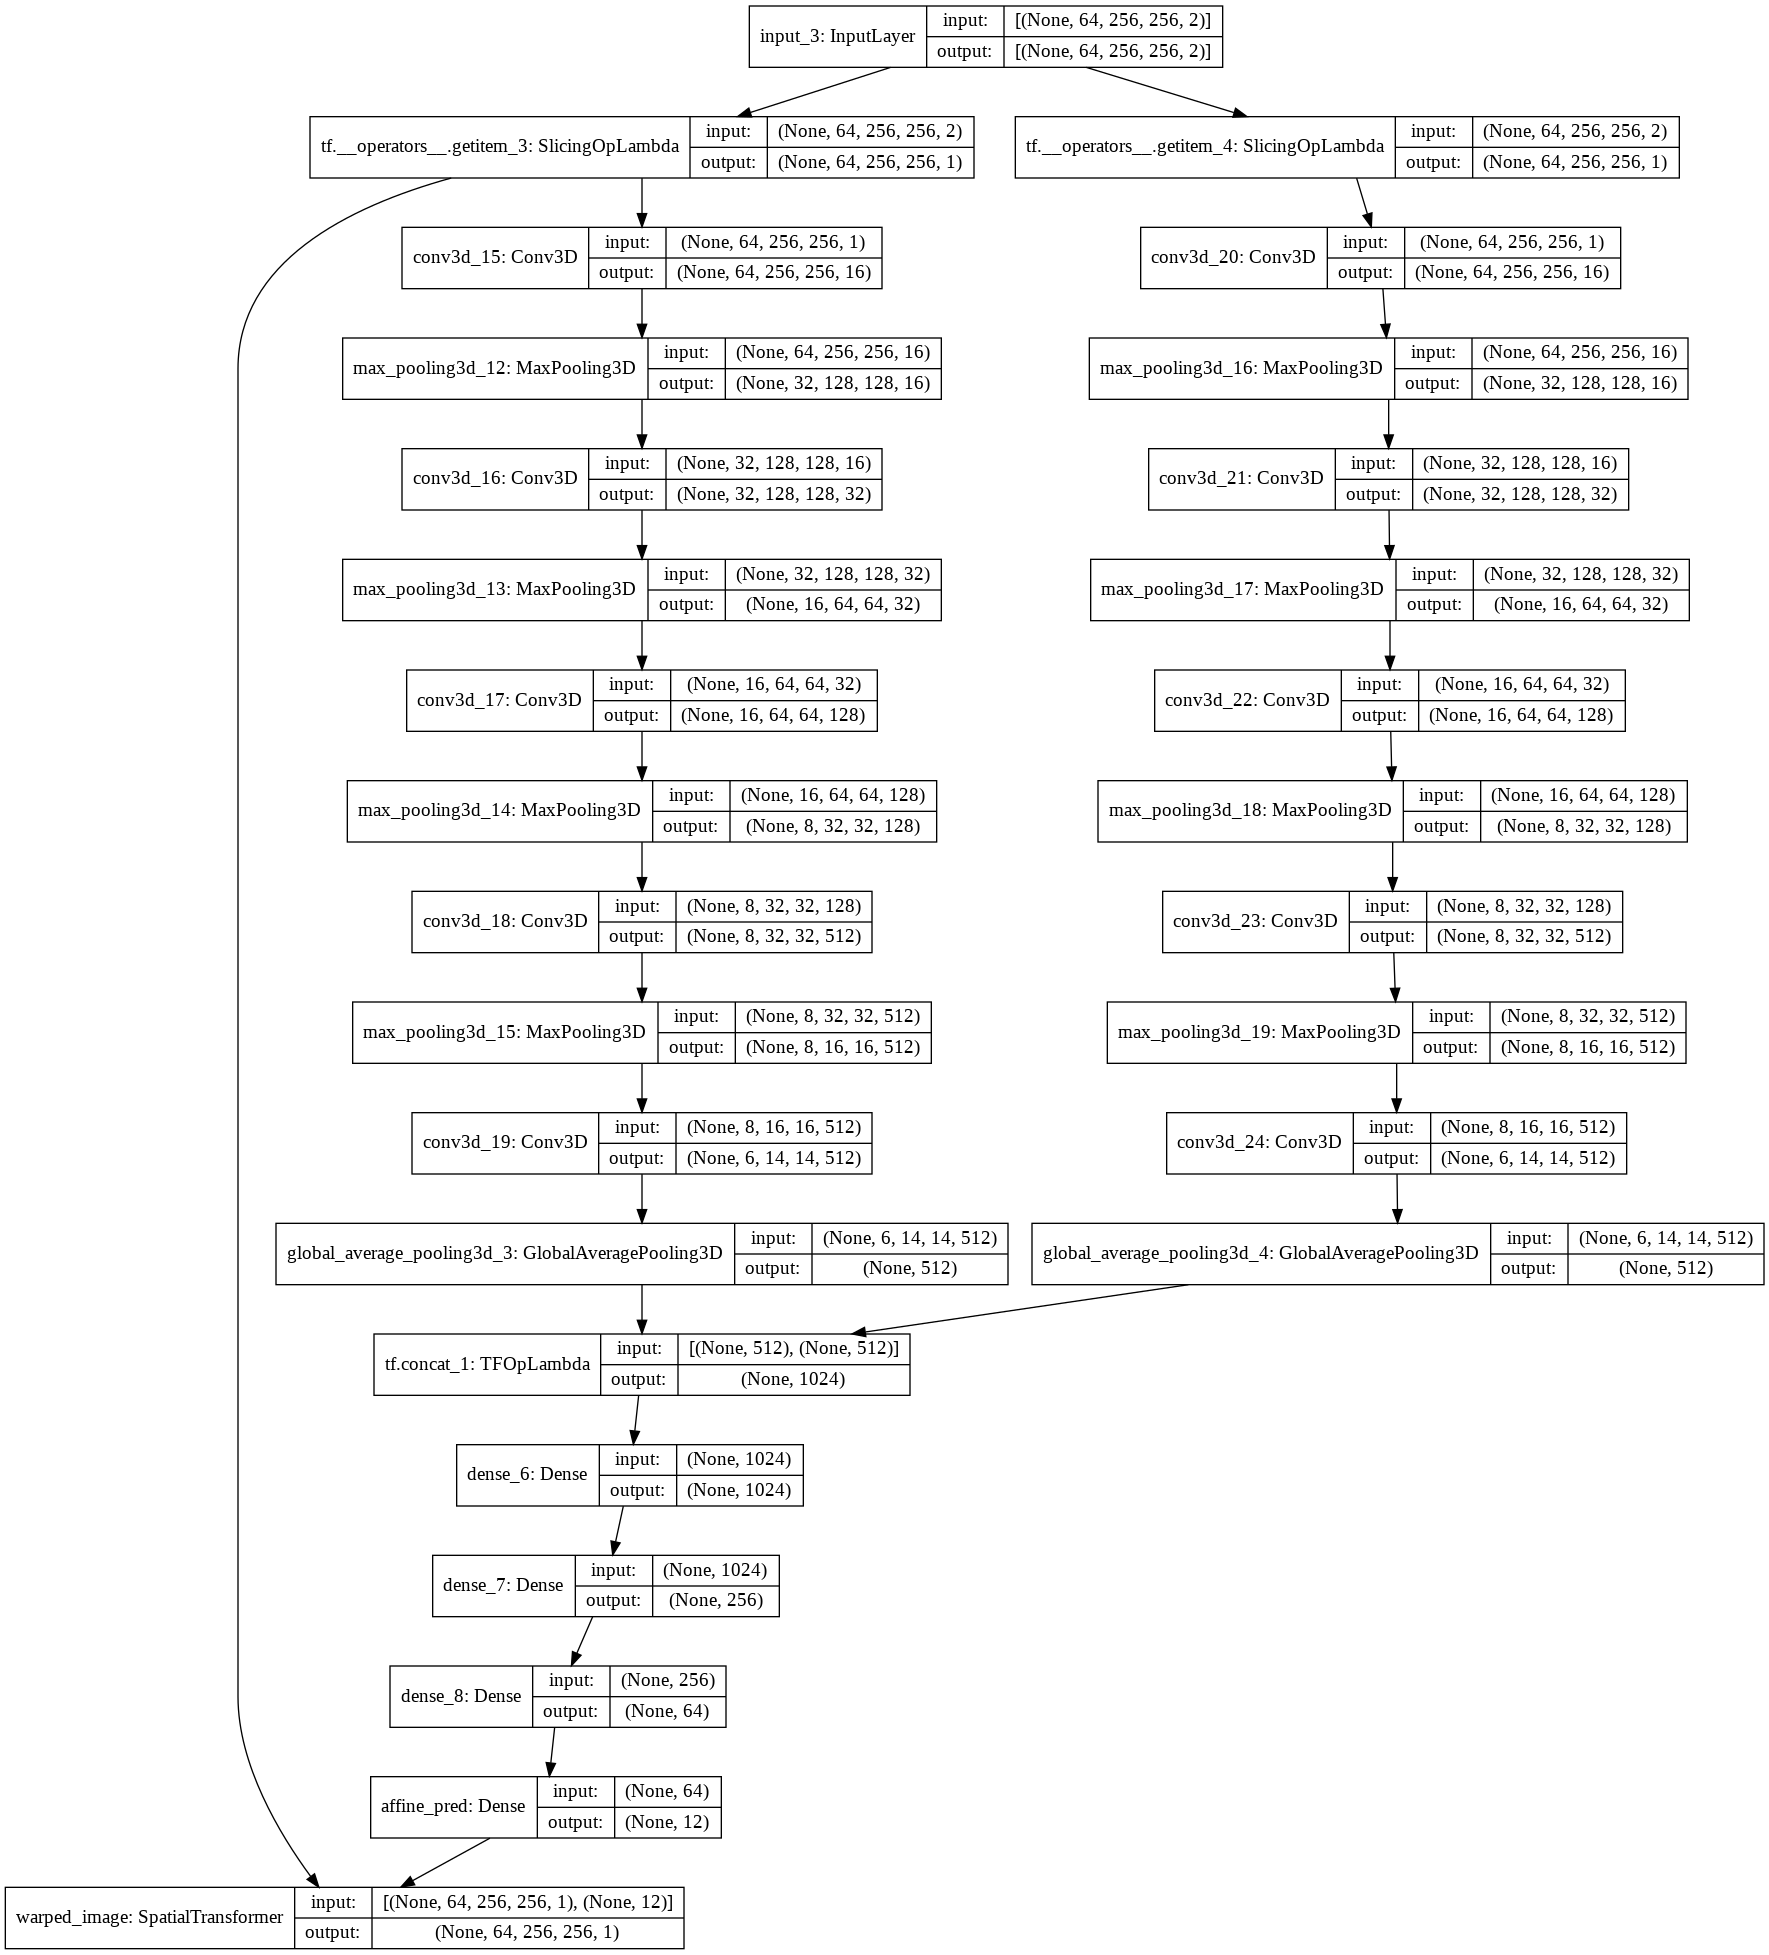

In [ ]:
keras.utils.plot_model(model, "baseline_DLIR_v2.png", show_shapes=True, expand_nested=True)

#### DLIR 2: one pipeline for concatenated input

In [ ]:
## DLIR
## 1. use lrelu for all relu
## 2. 5 layer of alternating 3x3x3 conv + 2/1x2x2 maxpool, the last pool is global average
## 3. two pipelines share weights

# Change the channel dimension to get the image pair shape
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
print(inputs.shape)

moving_input = inputs[..., 0:1]
# fixed_input = inputs[..., 1:2]

# down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
down_depths = [32, 64, 128, 512, 1024]
lrelu = layers.LeakyReLU(alpha=0.1)

# two pipelines share the weights:
pipeline = keras.Sequential([
    layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((1, 2, 2)),
    layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((1, 2, 2)),
    layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), padding='valid', activation=lrelu),
    layers.GlobalAveragePooling3D(), # [B, C]
])
# global_ave_4 = pipeline(moving_input)
# f_global_ave_4 = pipeline(fixed_input)
# concat_feats = tf.concat([global_ave_4, f_global_ave_4], axis = -1) # [B, C]

concat_feats = pipeline(inputs)
print(concat_feats.shape)

dense_0 = layers.Dense(1024, activation=lrelu)(concat_feats)
dense_1 = layers.Dense(128, activation=lrelu)(dense_0)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_1)


# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

(None, 64, 256, 256, 2)
(None, 1024)
Instructions for updating:
Use fn_output_signature instead
(None, 64, 256, 256, 1)


In [ ]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="baseline_model")
model.summary(line_length=150)

Model: "baseline_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 64, 256, 256, 2)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
sequential (Sequential)                          (None, 1024)                     16205216          input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
dense (Dense)                                    (None, 1024)         

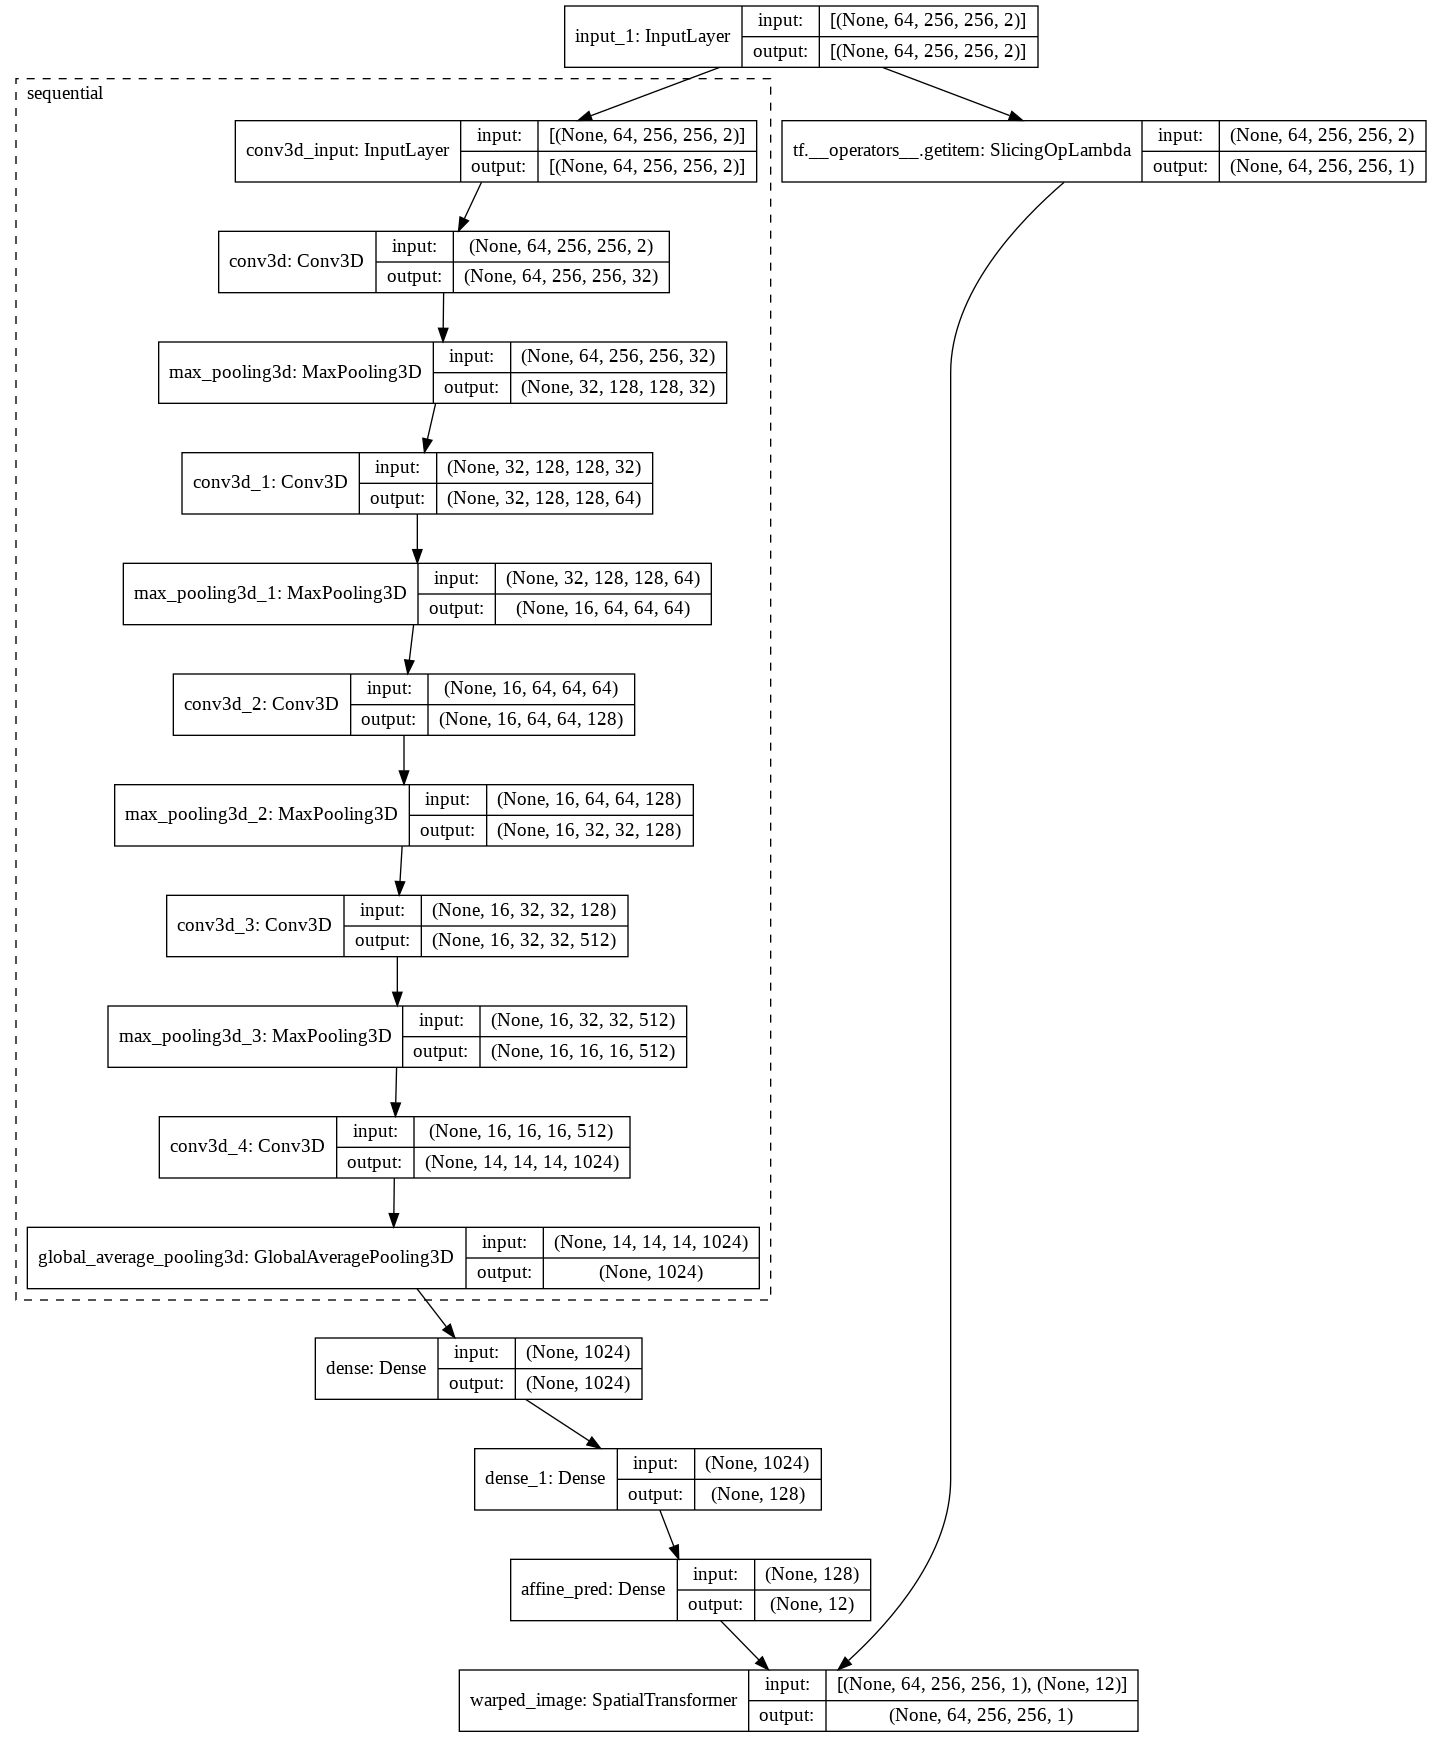

In [ ]:
keras.utils.plot_model(model, "./model_img/DLIR_2.png", show_shapes=True, expand_nested=True)

##### DLIR 2 v2

In [ ]:
## DLIR 2 v2
## 1. use lrelu for all relu
## 2. 5 layer of alternating 3x3x3 conv + 2/1x2x2 maxpool, the last pool is global average
## 3. two pipelines share weights

# Change the channel dimension to get the image pair shape
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
moving_input = inputs[..., 0:1]
print(inputs.shape)

# fixed_input = inputs[..., 1:2]

# down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
down_depths = [32, 64, 128, 512, 1024]
lrelu = layers.LeakyReLU(alpha=0.1)

# two pipelines share the weights:
pipeline = keras.Sequential([
    layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((1, 2, 2)),
    layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), padding='valid', activation=lrelu),
    layers.GlobalAveragePooling3D(), # [B, C]
])
concat_feats = pipeline(inputs)
print(concat_feats.shape)

dense_0 = layers.Dense(1024, activation=lrelu)(concat_feats)
dense_1 = layers.Dense(512, activation=lrelu)(dense_0) # 256
dense_2 = layers.Dense(128, activation=lrelu)(dense_1) # 64
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_2)

# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="baseline_model")
model.summary(line_length=150)

(None, 64, 256, 256, 2)
(None, 1024)
Instructions for updating:
Use fn_output_signature instead
(None, 64, 256, 256, 1)
Model: "baseline_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 64, 256, 256, 2)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
sequential (Sequential)                          (None, 1024)                     16205216          input_1[0][0]                                     
_____________________________________________________________________________________________________

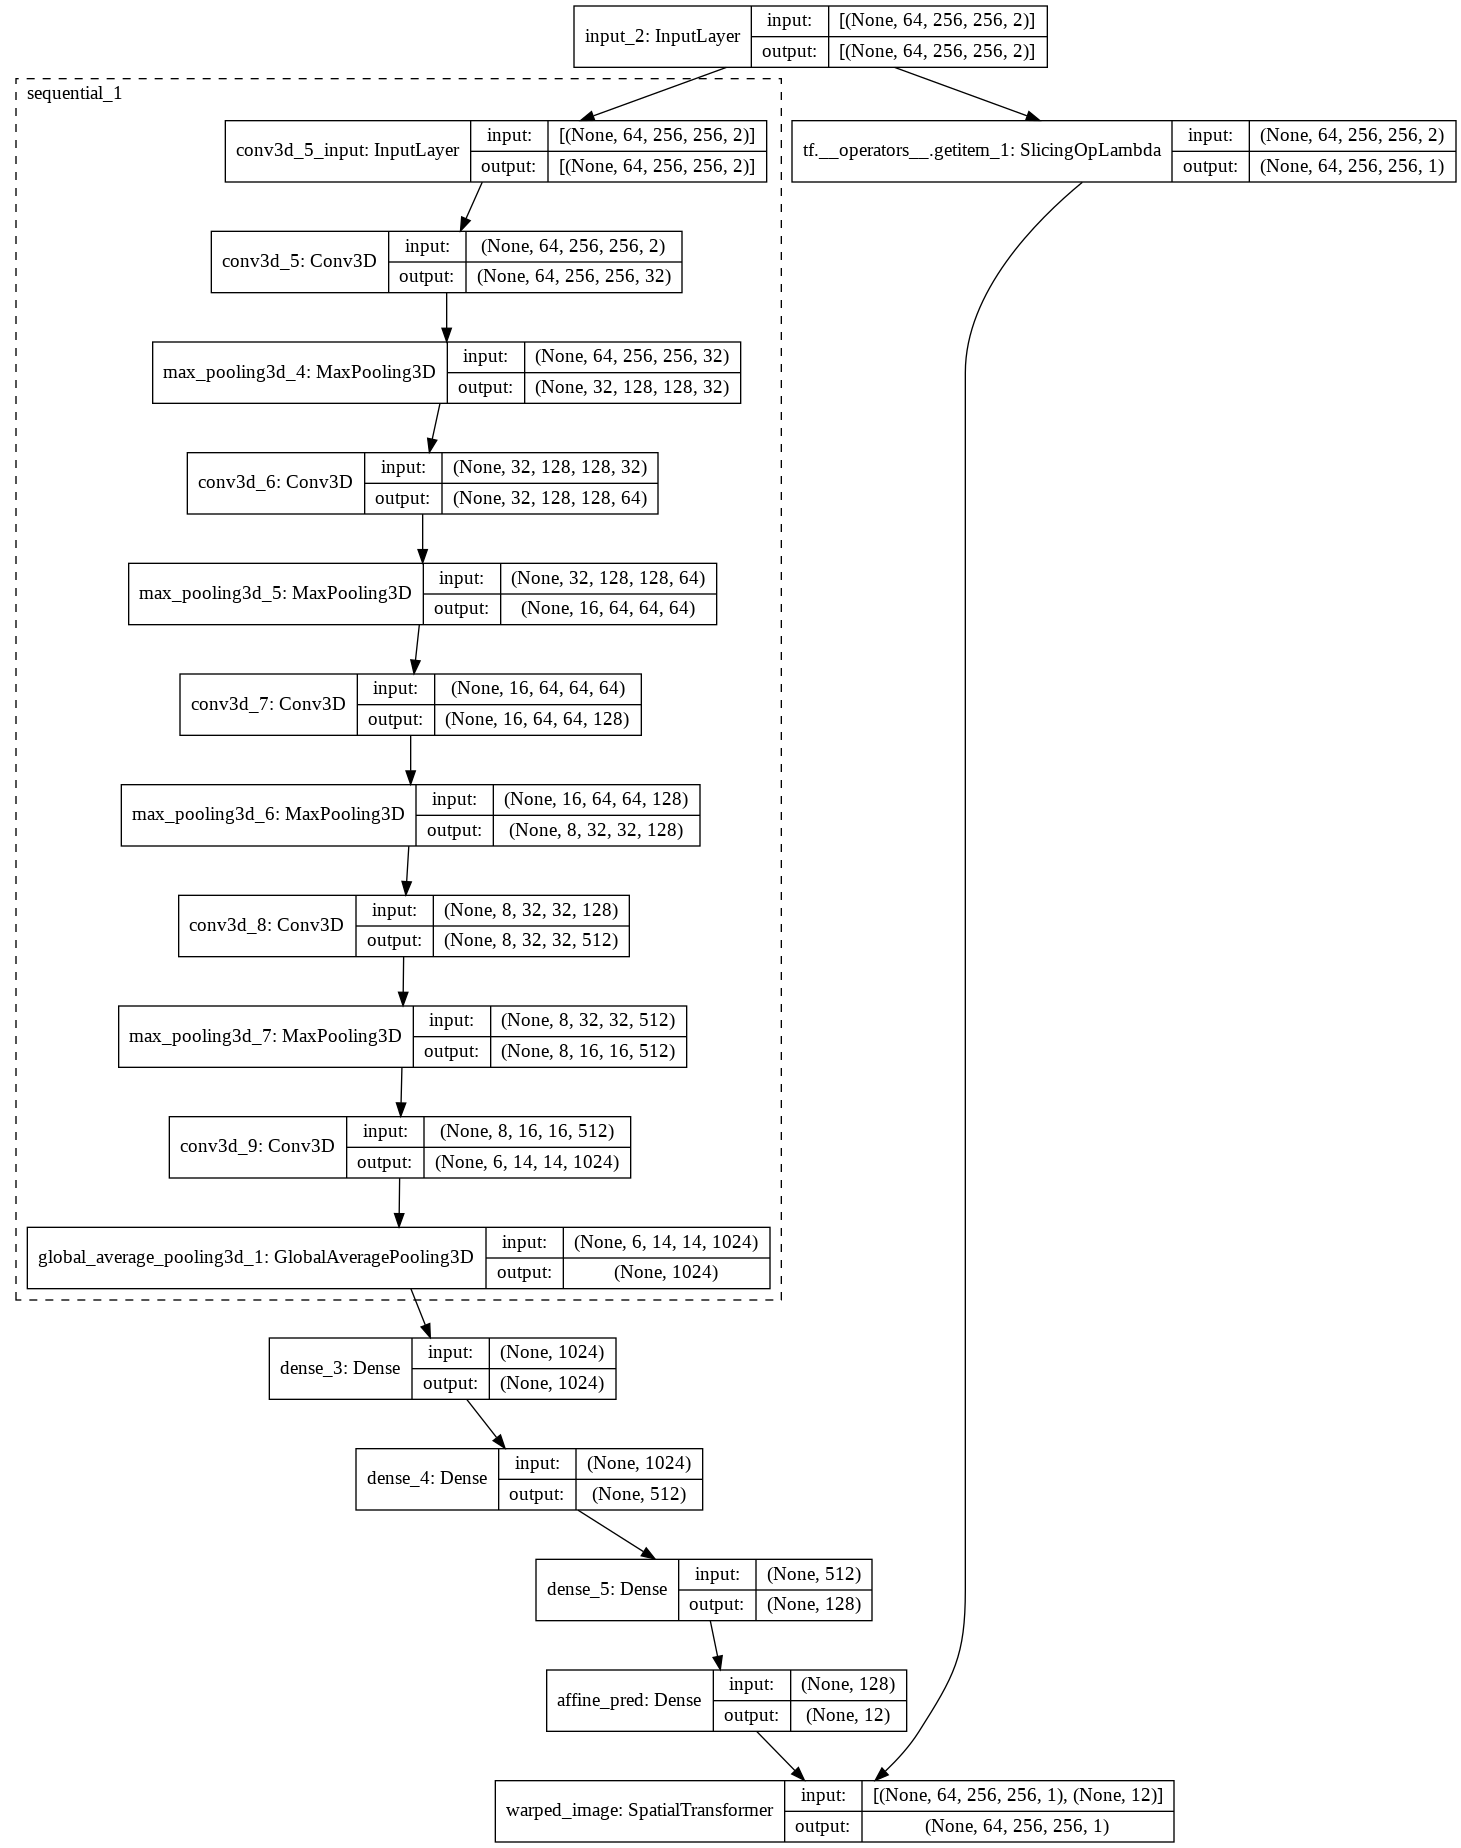

In [ ]:
keras.utils.plot_model(model, "./model_img/DLIR_2_v3.png", show_shapes=True, expand_nested=True)

#### DLIR: one pipeline for inputs separately

In [ ]:
## DLIR
## 1. use lrelu for all relu
## 2. 5 layer of alternating 3x3x3 conv + 2/1x2x2 maxpool, the last pool is global average
## 3. two pipelines share weights

# Change the channel dimension to get the image pair shape
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
print(inputs.shape)

moving_input = inputs[..., 0:1]
fixed_input = inputs[..., 1:2]

# down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
down_depths = [16, 64, 128, 512, 1024]
lrelu = layers.LeakyReLU(alpha=0.1)

# two pipelines share the weights:
pipeline = keras.Sequential([
    layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((1, 2, 2)),
    layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((1, 2, 2)),
    layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), padding='valid', activation=lrelu),
    layers.GlobalAveragePooling3D(), # [B, C]
])
global_ave_4 = pipeline(moving_input)
f_global_ave_4 = pipeline(fixed_input)
concat_feats = tf.concat([global_ave_4, f_global_ave_4], axis = -1) # [B, C]
print(concat_feats.shape)

dense_0 = layers.Dense(1024, activation=lrelu)(concat_feats)
dense_1 = layers.Dense(128, activation=lrelu)(dense_0)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_1)


# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

(None, 64, 256, 256, 2)
(None, 2048)
(None, 64, 256, 256, 1)


In [ ]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="baseline_model")
model.summary(line_length=150)

Model: "baseline_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_6 (InputLayer)                             [(None, 64, 256, 256, 2)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem_10 (SlicingOpLambda)    (None, 64, 256, 256, 1)          0                 input_6[0][0]                                     
______________________________________________________________________________________________________________________________________________________
tf.__operators__.getitem_11 (SlicingOpLambda)    (None, 64, 256, 256, 

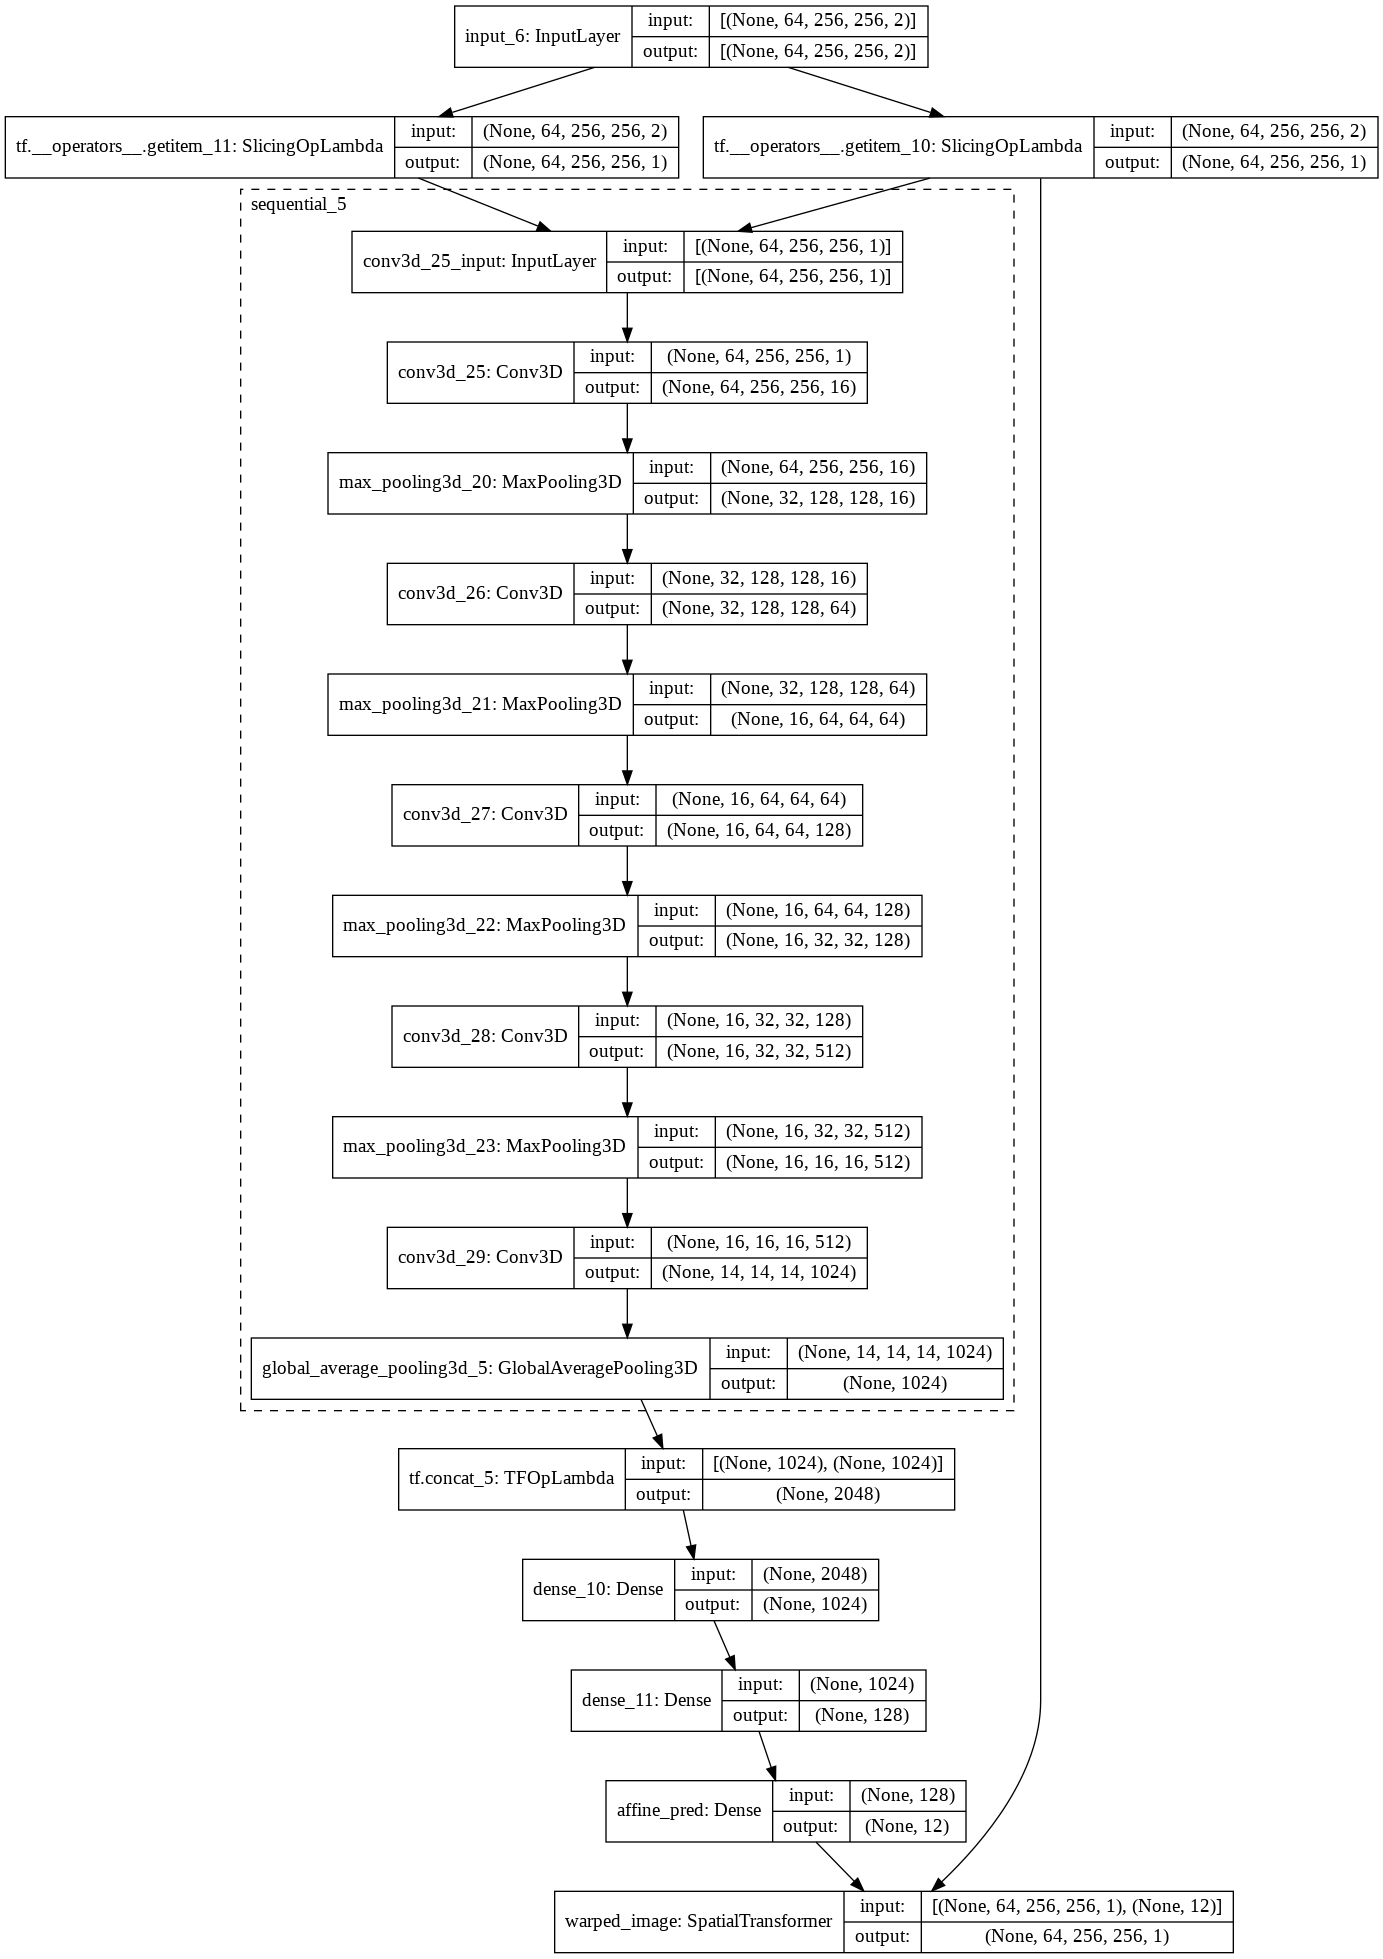

In [ ]:
keras.utils.plot_model(model, "./model_img/DLIR.png", show_shapes=True, expand_nested=True)

#### Separate representation with 18 affine param

In [ ]:
class affine_rep2param(layers.Layer):
    """
    A custom layer to convert affine transformation representation
    to the 12 affine transformation parameters
    """
    def __init__(self, name="affine_rep2param", **kwargs):
        kwargs.update({
            "trainable":False,
            "name":name
        })
        super(self.__class__, self).__init__(**kwargs)
        # super(self.__class__, self).__init__(trainable=False)
        self.rep_length = 18
    
    def build(self, input_shape):
        assert input_shape[1] == self.rep_length
        self.built = True
    
    def get_config(self):
        return super().get_config().copy()
    
    def call(self, input, training=True):
        assert input.shape[1] == self.rep_length
        # necessary for multi_gpu models ?
        input = K.reshape(input, (-1, self.rep_length))

        # convert affine rep to 12 params of affine transformation matrix
        if training:
            return tf.map_fn(self.single_rep2param, input, fn_output_signature=tf.float32)
        else: # using symmetric_orthogonalization
            return tf.map_fn(self.single_rep2param_svd, input, fn_output_signature=tf.float32)
        
        # # bs = tf.shape(input)[0] # tf.shape: https://stackoverflow.com/questions/38236175/get-the-size-of-a-variable-batch-dimension
        # # bs = input.get_shape()[0] 
        # trans, rot, scale, shear_param = input[:, 0:3], input[:, 3:12], \
        #                                  input[:, 12:15], input[:, 15:18]
        # affine_param = K.variable(lambda : K.eye(3)[None, ...])
        # affine_param = K.variable(lambda : K.repeat_elements(affine_param, rep=bs, axis=0))
        # affine_param = affine_param[:, 0, 1].assign(shear_param[:, 0])
        # affine_param = affine_param[:, 0, 2].assign(shear_param[:, 1])
        # affine_param = affine_param[:, 1 ,2].assign(shear_param[:, 2])
        # affine_param = affine_param * K.reshape(scale, (-1, 1, 3))
        # affine_param = K.reshape(rot, (-1, 3, 3)) @ affine_param
        # # if training:
        # #     affine_param = K.reshape(rot, (bs, 3, 3)) @ affine_param
        # # else:
        # #     pass
        # affine_param = tf.concat([affine_param, K.reshape(trans, (-1, 3, 1))], axis = 2)
        # return K.reshape(affine_param, (-1, 12))
        
    @classmethod
    def single_rep2param(cls, rep):
        """
        convert a single affine representation of length-18 tensors to 
        affine parameters of length-12 tensors
        """
        trans, rot, scale, shear_param = rep[0:3], rep[3:12], \
                                     rep[12:15], rep[15:18]
        # affine_param = K.variable(lambda : K.ones((3,4))) # lambda for variable(): https://stackoverflow.com/questions/61579678/valueerror-tensor-typed-variable-initializers-must-either-be-wrapped-in-an-init
        # affine_param = affine_param[:, 3].assign(trans) # assign: https://stackoverflow.com/questions/57454529/how-to-assign-a-value-to-the-tensor-object-in-keras
        # rot = K.reshape(rot, (3,3))
        # shear = K.variable(lambda : K.eye(3))
        # shear = shear[0,1].assign(shear_param[0])
        # shear = shear[0,2].assign(shear_param[1])
        # shear = shear[1,2].assign(shear_param[2])
        # shear = shear * scale
        # affine_param = affine_param[:, :3].assign(rot @ shear)
        # return K.reshape(affine_param, shape=[-1])

        affine_param = K.variable(lambda : K.eye(3))
        affine_param = affine_param[0,1].assign(shear_param[0])
        affine_param = affine_param[0,2].assign(shear_param[1])
        affine_param = affine_param[1,2].assign(shear_param[2])
        affine_param = affine_param * scale
        affine_param = K.reshape(rot, (3,3)) @ affine_param
        affine_param = tf.concat([affine_param, trans[:, None]], axis = 1)
        return K.reshape(affine_param, shape=[-1])

    @classmethod
    def single_rep2param_svd(cls, rep):
        """
        convert a single affine representation of length-18 tensors to 
        affine parameters of length-12 tensors using symmetric_orthogonalization:
        https://github.com/google-research/google-research/tree/master/special_orthogonalization 
        """
        trans, rot, scale, shear_param = rep[0:3], rep[3:12], \
                                     rep[12:15], rep[15:18]
        affine_param = K.variable(lambda : K.eye(3))
        affine_param = affine_param[0,1].assign(shear_param[0])
        affine_param = affine_param[0,2].assign(shear_param[1])
        affine_param = affine_param[1,2].assign(shear_param[2])
        affine_param = affine_param * scale

        rot = K.reshape(rot, (3,3))
        s,u,v = tf.linalg.svd(rot)
        vt = tf.transpose(v)
        det = tf.linalg.det(u @ vt)
        vt = tf.concat((vt[:2, :], vt[-1:, :] * det), axis=0)
        rot = u @ vt

        affine_param = rot @ affine_param
        affine_param = tf.concat([affine_param, trans[:, None]], axis = 1)
        return K.reshape(affine_param, shape=[-1])

In [ ]:
#### Modified model v3
## 1. use lrelu for all relu
## 2. affine module predicts 18 params

# Get rid of the batch dimension
imgPairShape = list(fixedImg.shape)[1:]
# Change the channel dimension to get the image pair shape
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
moving_input = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
fixed_input = tf.expand_dims(inputs[:, :, :, :, 1], axis = -1)

down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]
lrelu = layers.LeakyReLU(alpha=0.1)

conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation=lrelu)(moving_input)
print("conv_0: {}".format(conv_0.shape))
conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), activation=lrelu)(conv_0)
print("conv_1: {}".format(conv_1.shape))
filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(conv_1)
print("filtered_conv_1: {}".format(filtered_conv_1.shape))
conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation=lrelu)(filtered_conv_1)
print("conv_2: {}".format(conv_2.shape))
filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(conv_2)
print("filtered_conv_2: {}".format(filtered_conv_2.shape))
conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), activation=lrelu)(filtered_conv_2)
print("conv_3: {}".format(conv_3.shape))
conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation=lrelu)(conv_3)
print("conv_4: {}".format(conv_4.shape))

f_conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation=lrelu)(fixed_input)
f_conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), activation=lrelu)(f_conv_0)
f_filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(f_conv_1)
f_conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation=lrelu)(f_filtered_conv_1)
f_filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(f_conv_2)
f_conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), activation=lrelu)(f_filtered_conv_2)
f_conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation=lrelu)(f_conv_3)

concat_feats = tf.concat([conv_4, f_conv_4], axis = -1)
print(concat_feats.shape)

flattened = layers.Flatten()(concat_feats)
dense_0 = layers.Dense(1024, activation=lrelu)(flattened)
dense_1 = layers.Dense(256, activation=lrelu)(dense_0)
dense_2 = layers.Dense(64, activation=lrelu)(dense_1)
affine_pred_rep = layers.Dense(18, activation="linear", name="affine_pred_rep")(dense_2)
print("affine_pred_rep.shape", affine_pred_rep.shape)
affine_pred = affine_rep2param(name="affine_rep2param")(affine_pred_rep)

# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print("affine_warped.shape", affine_warped.shape)

conv_0: (None, 47, 113, 113, 4)
conv_1: (None, 42, 98, 98, 8)
filtered_conv_1: (None, 21, 49, 49, 8)
conv_2: (None, 16, 42, 42, 16)
filtered_conv_2: (None, 16, 21, 21, 16)
conv_3: (None, 13, 14, 14, 24)
conv_4: (None, 10, 11, 11, 32)
(None, 10, 11, 11, 64)
affine_pred_rep.shape (None, 18)
self.bs None
Instructions for updating:
Use fn_output_signature instead
affine_warped.shape (None, 52, 256, 256, 1)


In [ ]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred_rep], name="combined_model")
model.summary(line_length=150)

In [ ]:
keras.utils.plot_model(model, "test4.png", show_shapes=True)

In [ ]:
# """
# y = (deformed_img, affine_trf)
# """
# def affine_loss(y_actual, y_pred):
#     y_actual = y_actual[0]
#     y_pred = y_pred[0]
#     tgtDiag = [y_actual[0]] + [y_actual[5]] + [y_actual[10]]
#     predDiag = [y_pred[0]] + [y_pred[5]] + [y_pred[10]]
#     tgtCorner = y_actual[1:3] + [y_actual[4]] + [y_actual[6]] + y_actual[8:10]
#     predCorner = y_pred[1:3] + [y_pred[4]] + [y_pred[6]] + y_pred[8:10]
#     tgtTranslation = [y_actual[3]] + [y_actual[7]] + [y_actual[11]]
#     predTranslation = [y_pred[3]] + [y_pred[7]] + [y_pred[11]]
#     mse = tf.keras.losses.MeanSquaredError()
#     diag_loss = mse(tgtDiag, predDiag)
#     corner_loss = mse(tgtCorner, predCorner)
#     translation_loss = mse(tgtTranslation, predTranslation)
#     return corner_loss * 10 + diag_loss * 10 + translation_loss

### Separate representation with 21 affine params
include shear, dataset approach 2

To recreate the shear matrix: (test run on trainDataSize=20,valDataSize=5,epochs=10)
* Use tf.eye and assign: tf tensor cannot support item assignment
* concat? don't know how many batches beforehand, so concat 5 tensors, each of length of bs,  for three times. The runtime is too long: 70-80s
* compute instead of assign: need a mask first, but we don't know the bs beforehand, so the same as concat, which is to take bs axis in the process
* use variable inside call:
 * cannot lifted outside tf.function (direct init value)
 * external symbolic link (lambda as init value)
* use vairable (created outside the tf.function):
 * weight shape \[3,3] and use map_fn: less efficient and more overhead
 * weight shape \[bs, 3,3] and all vectorized operation in call: cannot process single image at test time conveniently

In [33]:
## Custom tf layer to convert separate affine parameters to 
#  the standard 12 params
#  tf layer tutorial: https://www.tensorflow.org/guide/keras/custom_layers_and_models#privileged_training_argument_in_the_call_method
class affine_rep2param(layers.Layer):
    """
    A custom layer to convert 21 affine transformation parameters
    to the 12 affine transformation parameters
    """
    def __init__(self, name="affine_rep2param", max_batch=2, **kwargs):
        """
        arg:
            max_batch: the max depth for initializting shear matrices
        """
        self.max_batch = max_batch
        if name not in kwargs:
            kwargs.update({
                "trainable":False,
                "name":name,
            })
        super(self.__class__, self).__init__(**kwargs)
        self.rep_length = 21 

        # layer var, use Variable since tensor cannot do item assignment
        self.shearX_M = tf.Variable(initial_value=tf.eye(3, batch_shape=[max_batch]), trainable=False, name=f"{self.name}/shearX_M")
        self.shearY_M = tf.Variable(initial_value=tf.eye(3, batch_shape=[max_batch]), trainable=False, name=f"{self.name}/shearY_M")
        self.shearZ_M = tf.Variable(initial_value=tf.eye(3, batch_shape=[max_batch]), trainable=False, name=f"{self.name}/shearZ_M")
    
    def build(self, input_shape):
        assert input_shape[1] == self.rep_length
        self.built = True
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({"max_batch": self.max_batch})
        return config
    
    def call(self, input, training=True):
        assert input.shape[1] == self.rep_length
        # assert input.shape[0] < self.max_batch

        # # convert affine rep to 12 params of affine transformation matrix
        # if training: # have to separate the two cases since fn should only accepts one input
        #     # return self.single_rep2param_(input)
        #     return tf.map_fn(self.single_rep2param, input, fn_output_signature=tf.float32)#, parallel_iterations=batch_size)
        # else: # using symmetric_orthogonalization
        #     # return self.single_rep2param_svd_(input)
        #     return tf.map_fn(self.single_rep2param_svd, input, fn_output_signature=tf.float32)#, parallel_iterations=batch_size)
        
        # # bs = tf.shape(input)[0] # tf.shape: https://stackoverflow.com/questions/38236175/get-the-size-of-a-variable-batch-dimension
        # # bs = input.get_shape()[0] 

        # ### approach using concat: too slow
        # input_batch = tf.shape(input)[0]
        # trans, rot, shear, scale = input[:, 0:3], input[:, 3:12], input[:, 12:18], input[:, 18:21]
        # shear_matrix = tf.reshape(tf.eye(3, batch_shape=[input_batch]), (-1, 9))
        # shearX_M = tf.reshape(tf.concat([shear_matrix[:, :3], shear[:, 0:1], shear_matrix[:, 4:6], shear[:, 1:2], shear_matrix[:, 7:9]], -1), (-1, 3,3))
        # shearY_M = tf.reshape(tf.concat([shear_matrix[:, :1], shear[:, 2:3], shear_matrix[:, 2:7], shear[:, 3:4], shear_matrix[:, 8:9]], -1), (-1, 3,3))
        # shearZ_M = tf.reshape(tf.concat([shear_matrix[:, :2], shear[:, 4:5], shear_matrix[:, 3:5], shear[:, 5:6], shear_matrix[:, 6:9]], -1), (-1, 3,3))

        input_batch = tf.shape(input)[0]
        trans, rot, shear, scale = input[:, 0:3], input[:, 3:12], input[:, 12:18], input[:, 18:21]
        if not training and input_batch < self.max_batch:
            self.shearX_M[:input_batch, 1:3, 0].assign(shear[:, :2])
            self.shearY_M[:input_batch, 0, 1].assign(shear[:, 2])
            self.shearY_M[:input_batch, 2, 1].assign(shear[:, 3])
            self.shearZ_M[:input_batch, 0:2, 2].assign(shear[:, 4:])
            affine_param = self.shearX_M[:input_batch] @ self.shearY_M[:input_batch] @ self.shearZ_M[:input_batch] * tf.reshape(scale, (-1, 1, 3))
        else:
            self.shearX_M[:, 1:3, 0].assign(shear[:, :2])
            self.shearY_M[:, 0, 1].assign(shear[:, 2])
            self.shearY_M[:, 2, 1].assign(shear[:, 3])
            self.shearZ_M[:, 0:2, 2].assign(shear[:, 4:])
            affine_param = self.shearX_M @ self.shearY_M @ self.shearZ_M * tf.reshape(scale, (-1, 1, 3))

        rot = tf.reshape(rot, (-1, 3, 3))
        ## symmetric orthogonalization
        if training:
            s,u,v = tf.linalg.svd(rot)
            vt = tf.transpose(v, perm=[0,2,1])  # [bs,3,3]
            det = tf.linalg.det(u @ vt)   # [bs, 1]
            vt = tf.concat((vt[:, :2, :], vt[:, -1:, :] * tf.reshape(det, (-1,1,1))), axis=1) # flip last row if det=-1
            rot = u @ vt

        affine_param = rot @ affine_param
        affine_param = tf.concat([affine_param, K.reshape(trans, (-1, 3, 1))], axis = 2)
        return K.reshape(affine_param, (-1, 12))

    ### parallelism is slower than no parallelism
    # @tf.function
    # def single_rep2param_(self, input):
    #     return tf.map_fn(self.single_rep2param, input, fn_output_signature=tf.float32, parallel_iterations=batch_size)
    # @tf.function
    # def single_rep2param_svd_(self, input):
    #     return tf.map_fn(self.single_rep2param_svd, input, fn_output_signature=tf.float32, parallel_iterations=batch_size)

    # def single_rep2param(self, rep):
    #     """
    #     convert a single affine representation of length-21 tensors to 
    #     affine parameters of length-12 tensors
    #     Args:
    #         rep: 21 param [21]
    #     """
    #     trans, rot, shear, scale = rep[0:3], rep[3:12], rep[12:18], rep[18:21]
    #     # affine_param = K.variable(lambda : K.ones((3,4))) # lambda for variable(): https://stackoverflow.com/questions/61579678/valueerror-tensor-typed-variable-initializers-must-either-be-wrapped-in-an-init
    #     # affine_param = affine_param[:, 3].assign(trans) # assign: https://stackoverflow.com/questions/57454529/how-to-assign-a-value-to-the-tensor-object-in-keras

    #     # shearX_M = K.variable(lambda : K.eye(3, dtype=tf.float32))
    #     # shearY_M = K.variable(lambda : K.eye(3, dtype=tf.float32))
    #     # shearZ_M = K.variable(lambda : K.eye(3, dtype=tf.float32))
    #     # shearX_M = shearX_M[1:3, 0].assign(shear[:2])
    #     # shearY_M = shearY_M[0, 1].assign(shear[2])
    #     # shearY_M = shearY_M[2, 1].assign(shear[3])
    #     # shearZ_M = shearZ_M[0:2, 2].assign(shear[4:])

    #     self.shearX_M[1:3, 0].assign(shear[:2])
    #     self.shearY_M[0, 1].assign(shear[2])
    #     self.shearY_M[2, 1].assign(shear[3])
    #     self.shearZ_M[0:2, 2].assign(shear[4:])
    #     affine_param = self.shearX_M @ self.shearY_M @ self.shearZ_M * scale

    #     affine_param = K.reshape(rot, (3,3)) @ affine_param
    #     affine_param = tf.concat([affine_param, trans[:, None]], axis = 1)
    #     return K.reshape(affine_param, shape=[-1])

    # def single_rep2param_svd(self, rep):
    #     """
    #     convert a single affine representation of length-18 tensors to 
    #     affine parameters of length-12 tensors using symmetric_orthogonalization:
    #     https://github.com/google-research/google-research/tree/master/special_orthogonalization 
    #     """
    #     trans, rot, shear, scale = rep[0:3], rep[3:12], rep[12:18], rep[18:21]

    #     self.shearX_M[1:3, 0].assign(shear[:2])
    #     self.shearY_M[0, 1].assign(shear[2])
    #     self.shearY_M[2, 1].assign(shear[3])
    #     self.shearZ_M[0:2, 2].assign(shear[4:])
    #     affine_param = self.shearX_M @ self.shearY_M @ self.shearZ_M * scale

    #     ## symmetric orthogonalization
    #     rot = K.reshape(rot, (3,3))
    #     s,u,v = tf.linalg.svd(rot)
    #     vt = tf.transpose(tf.math.conj(v))
    #     det = tf.linalg.det(u @ vt)
    #     vt = tf.concat((vt[:2, :], vt[-1:, :] * det), axis=0) # flip last row if det=-1
    #     rot = u @ vt

    #     affine_param = rot @ affine_param
    #     affine_param = tf.concat([affine_param, trans[:, None]], axis = 1)
    #     return K.reshape(affine_param, shape=[-1])

In [94]:
# ## check conversion
# ele = np.load('./data/affineTrainingData3/test/affine_2_0.npz')
trf_rep = tf.constant(np.load('./data/affineTrainingData3/test/affine_2_0.npz')["trf_21param"][0].astype("float32"))
trf_param = tf.constant(np.load('./data/affineTrainingData3/test/affine_2_0.npz')["trf"][0].astype("float32"))
trf_rep.shape, trf_param.shape

affine_pred = affine_rep2param(name="affine_rep2param", max_batch=2)

# ### check single_rep2param with map_fn
# # affine_pred.single_rep2param(trf_rep)#-trf_param
# # tf.debugging.assert_near(affine_pred.single_rep2param(trf_rep), trf_param)
# # # check single_rep2param_svd
# # affine_pred.single_rep2param_svd(trf_rep)
# # tf.debugging.assert_near(affine_pred.single_rep2param_svd(trf_rep), trf_param)


## check single_rep2param vectorization
tf.debugging.assert_near(affine_pred(trf_rep[None, :])[0], trf_param)

In [90]:
affine_pred = affine_rep2param(name="affine_rep2param", max_batch=2)(affine_pred_rep)

In [ ]:
#@title old layer
# class affine_rep2param(layers.Layer):
#     """
#     A custom layer to convert 21 affine transformation parameters
#     to the 12 affine transformation parameters
#     """
#     def __init__(self, name="affine_rep2param", **kwargs):
#         kwargs.update({
#             "trainable":False,
#             "name":name
#         })
#         super(self.__class__, self).__init__(**kwargs)
#         self.rep_length = 21
    
#     def build(self, input_shape):
#         assert input_shape[1] == self.rep_length
#         # self.built = True
    
#     def get_config(self):
#         return super().get_config().copy()
    
#     def call(self, input, training=True):
#         assert input.shape[1] == self.rep_length
#         # necessary for multi_gpu models ?
#         input = K.reshape(input, (-1, self.rep_length))

#         # convert affine rep to 12 params of affine transformation matrix
#         if training:
#             # return self.single_rep2param_(input)
#             return tf.map_fn(self.single_rep2param, input, fn_output_signature=tf.float32)#, parallel_iterations=batch_size)
#         else: # using symmetric_orthogonalization
#             # return self.single_rep2param_svd_(input)
#             return tf.map_fn(self.single_rep2param_svd, input, fn_output_signature=tf.float32)#, parallel_iterations=batch_size)
        
#         # # bs = tf.shape(input)[0] # tf.shape: https://stackoverflow.com/questions/38236175/get-the-size-of-a-variable-batch-dimension
#         # # bs = input.get_shape()[0] 
#         # trans, rot, scale, shear_param = input[:, 0:3], input[:, 3:12], \
#         #                                  input[:, 12:15], input[:, 15:18]
#         # affine_param = K.variable(lambda : K.eye(3)[None, ...])
#         # affine_param = K.variable(lambda : K.repeat_elements(affine_param, rep=bs, axis=0))
#         # affine_param = affine_param[:, 0, 1].assign(shear_param[:, 0])
#         # affine_param = affine_param[:, 0, 2].assign(shear_param[:, 1])
#         # affine_param = affine_param[:, 1 ,2].assign(shear_param[:, 2])
#         # affine_param = affine_param * K.reshape(scale, (-1, 1, 3))
#         # affine_param = K.reshape(rot, (-1, 3, 3)) @ affine_param
#         # # if training:
#         # #     affine_param = K.reshape(rot, (bs, 3, 3)) @ affine_param
#         # # else:
#         # #     pass
#         # affine_param = tf.concat([affine_param, K.reshape(trans, (-1, 3, 1))], axis = 2)
#         # return K.reshape(affine_param, (-1, 12))

#     # @tf.function
#     # def single_rep2param_(self, input):
#     #     return tf.map_fn(self.single_rep2param, input, fn_output_signature=tf.float32, parallel_iterations=batch_size)
#     # @tf.function
#     # def single_rep2param_svd_(self, input):
#     #     return tf.map_fn(self.single_rep2param_svd, input, fn_output_signature=tf.float32, parallel_iterations=batch_size)

#     @classmethod
#     def single_rep2param(cls, rep):
#         """
#         convert a single affine representation of length-21 tensors to 
#         affine parameters of length-12 tensors
#         Args:
#             rep: 21 param [21]
#         """
#         trans, rot, shear, scale = rep[0:3], rep[3:12], rep[12:18], rep[18:21]
#         # affine_param = K.variable(lambda : K.ones((3,4))) # lambda for variable(): https://stackoverflow.com/questions/61579678/valueerror-tensor-typed-variable-initializers-must-either-be-wrapped-in-an-init
#         # affine_param = affine_param[:, 3].assign(trans) # assign: https://stackoverflow.com/questions/57454529/how-to-assign-a-value-to-the-tensor-object-in-keras

#         # affine_param = K.variable(lambda : K.eye(3, dtype=tf.float32))
#         shearX_M = K.variable(lambda : K.eye(3, dtype=tf.float32))
#         shearY_M = K.variable(lambda : K.eye(3, dtype=tf.float32))
#         shearZ_M = K.variable(lambda : K.eye(3, dtype=tf.float32))

#         shearX_M = shearX_M[1:3, 0].assign(shear[:2])
#         shearY_M = shearY_M[0, 1].assign(shear[2])
#         shearY_M = shearY_M[2, 1].assign(shear[3])
#         shearZ_M = shearZ_M[0:2, 2].assign(shear[4:])
#         affine_param = shearX_M @ shearY_M @ shearZ_M * scale
#         affine_param = K.reshape(rot, (3,3)) @ affine_param
#         affine_param = tf.concat([affine_param, trans[:, None]], axis = 1)
#         return K.reshape(affine_param, shape=[-1])

#     @classmethod
#     def single_rep2param_svd(cls, rep):
#         """
#         convert a single affine representation of length-18 tensors to 
#         affine parameters of length-12 tensors using symmetric_orthogonalization:
#         https://github.com/google-research/google-research/tree/master/special_orthogonalization 
#         """
#         trans, rot, shear, scale = rep[0:3], rep[3:12], rep[12:18], rep[18:21]
#         # affine_param =K.eye(3)
#         shearX_M = K.variable(lambda : K.eye(3, dtype=tf.float32))
#         shearY_M = K.variable(lambda : K.eye(3, dtype=tf.float32))
#         shearZ_M = K.variable(lambda : K.eye(3, dtype=tf.float32))

#         shearX_M = shearX_M[1:3, 0].assign(shear[:2])
#         shearY_M = shearY_M[0, 1].assign(shear[2])
#         shearY_M = shearY_M[2, 1].assign(shear[3])
#         shearZ_M = shearZ_M[0:2, 2].assign(shear[4:])
#         affine_param = shearX_M @ shearY_M @ shearZ_M * scale

#         rot = K.reshape(rot, (3,3))
#         s,u,v = tf.linalg.svd(rot)
#         vt = tf.transpose(tf.math.conj(v))
#         det = tf.linalg.det(u @ vt)
#         vt = tf.concat((vt[:2, :], vt[-1:, :] * det), axis=0) # flip last row if det=-1
#         rot = u @ vt

#         affine_param = rot @ affine_param
#         affine_param = tf.concat([affine_param, trans[:, None]], axis = 1)
#         return K.reshape(affine_param, shape=[-1])

#### T1

In [34]:
#### DLIR 2 + 21 affine param
## 1. use lrelu for all relu
## 2. 5 layer of alternating 3x3x3 conv + 2/1x2x2 maxpool, the last pool is global average
## 3. two pipelines share weights
## 4. affine module predicts 21 params

# Change the channel dimension to get the image pair shape
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
moving_input = inputs[..., 0:1]
print(inputs.shape)

param_len = 21
down_depths = [32, 64, 128, 512, 1024]
lrelu = layers.LeakyReLU(alpha=0.1)

# two pipelines share the weights:
pipeline = keras.Sequential([
    layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((1, 2, 2)), #1
    layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), padding='valid', activation=lrelu),
    layers.GlobalAveragePooling3D(), # [B, C]
])
concat_feats = pipeline(inputs)
print(concat_feats.shape)

dense_0 = layers.Dense(1024, activation=lrelu)(concat_feats)
dense_1 = layers.Dense(512, activation=lrelu)(dense_0) # 256
dense_2 = layers.Dense(128, activation=lrelu)(dense_1) # 64
affine_pred_rep = layers.Dense(param_len, activation="linear", name="affine_pred_rep")(dense_2)
print("affine_pred_rep.shape: ", affine_pred_rep.shape)
# affine_pred = affine_rep2param(name="affine_rep2param")(affine_pred_rep)
affine_pred = affine_rep2param(name="affine_rep2param", max_batch=batch_size)(affine_pred_rep)

# affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_2)

# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print("affine_warped.shape: ", affine_warped.shape)

model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred_rep], name="DLIR2_21param")
model.summary(line_length=150)

(None, 64, 256, 256, 2)
(None, 1024)
affine_pred_rep.shape:  (None, 21)
affine_warped.shape:  (None, 64, 256, 256, 1)
Model: "DLIR2_21param"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_4 (InputLayer)                            [(None, 64, 256, 256, 2)]        0                 []                                                
                                                                                                                                                      
 sequential_3 (Sequential)                       (None, 1024)                     16205216          ['input_4[0][0]']                                 
                                                                                                        

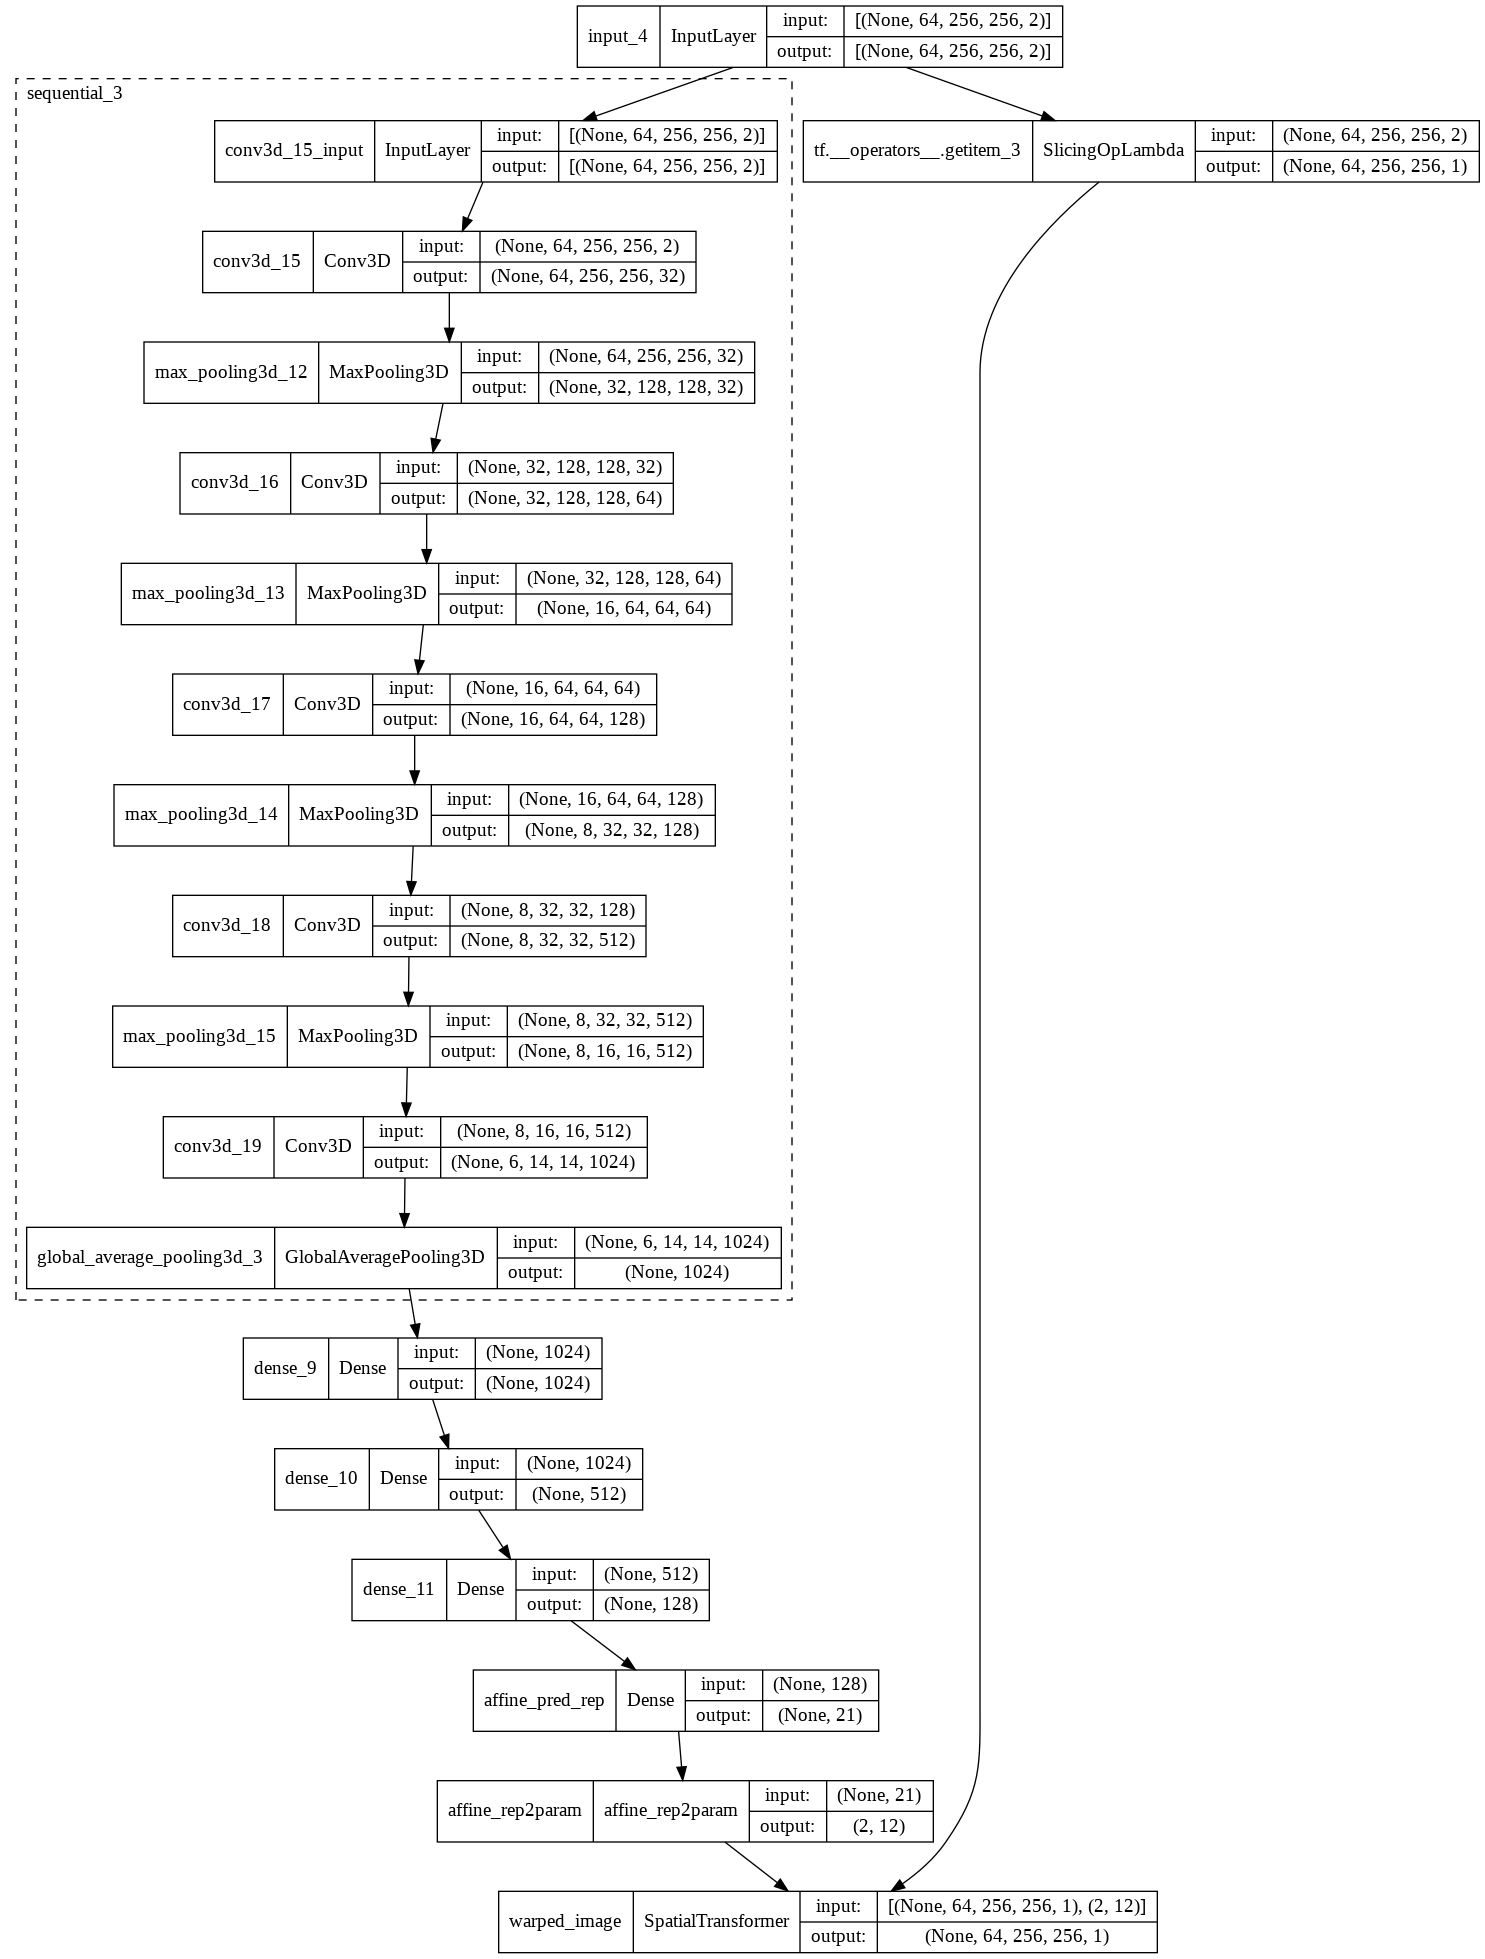

In [35]:
keras.utils.plot_model(model, "./model_img/DLIR_2_v3_21param.png", show_shapes=True, expand_nested=True)

#### T2

In [50]:
### DLIR 2 + 21 affine param + no global pool 
## 1. use lrelu for all relu
## 2. 5 layer of alternating 3x3x3 conv + 2/1x2x2 maxpool, the last pool is flatten
## 3. two pipelines share weights
## 4. affine module predicts 21 params

# Change the channel dimension to get the image pair shape
imgPairShape = list(fixed_input_shape)[1:]
imgPairShape[-1] = 2
inputs = keras.Input(shape = imgPairShape)
moving_input = inputs[..., 0:1]
print(inputs.shape)

param_len = 21
down_depths = [32, 64, 128, 256, 256]
lrelu = layers.LeakyReLU(alpha=0.1)

# two pipelines share the weights:
pipeline = keras.Sequential([
    layers.Conv3D(filters=down_depths[0], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    layers.Conv3D(filters=down_depths[4], kernel_size=(3, 3, 3), padding='same', activation=lrelu),
    layers.MaxPool3D((2, 2, 2)),
    # layers.GlobalAveragePooling3D(), # [B, C]
    layers.Flatten(),
])
concat_feats = pipeline(inputs)
print(concat_feats.shape)

dense_0 = layers.Dense(512, activation=lrelu)(concat_feats)
dense_1 = layers.Dense(256, activation=lrelu)(dense_0) # 256
dense_2 = layers.Dense(64, activation=lrelu)(dense_1) # 64
affine_pred_rep = layers.Dense(param_len, activation="linear", name="affine_pred_rep")(dense_2)
print("affine_pred_rep.shape: ", affine_pred_rep.shape)
affine_pred = affine_rep2param(name="affine_rep2param")(affine_pred_rep)

# affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(dense_2)

# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print("affine_warped.shape: ", affine_warped.shape)

model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred_rep], name="DLIR2_21param")
model.summary(line_length=150)

(None, 64, 256, 256, 2)
(None, 32768)
affine_pred_rep.shape:  (None, 21)
affine_warped.shape:  (None, 64, 256, 256, 1)
Model: "DLIR2_21param"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_11 (InputLayer)                           [(None, 64, 256, 256, 2)]        0                 []                                                
                                                                                                                                                      
 sequential_10 (Sequential)                      (None, 32768)                    2933152           ['input_11[0][0]']                                
                                                                                                       

### Train

In [36]:
## Training 
# experiment_name = "qr_decomp_svd_rot_batchnorm"
# experiment_name = "qr_decomp_svd_rot"
experiment_name = "DLIR_2_dataV3_21param"
lr = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
output_dir = os.path.join("checkpoints", experiment_name, time.strftime("%m_%d_%H-%M-%S"))
save_callback = ModelCheckpoint(os.path.join(output_dir, "{epoch:02d}.h5"),
                                # monitor='val_warped_image_mean_squared_error',
                                save_best_only=True,
                                )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=0.000005)

# normal representation
# model.compile(optimizer=optimizer,
#               loss={"warped_image":"mean_squared_error", "affine_pred":"mean_squared_error"},
#               loss_weights={"warped_image":4, "affine_pred":1},
#               ) #run_eagerly=True)

# separate affine matrix representation
model.compile(optimizer=optimizer,
              loss={"warped_image":"mean_squared_error", "affine_pred_rep":"mean_absolute_error"},
            #   loss_weights={"warped_image":1, "affine_pred":1},
              loss_weights={"warped_image":4, "affine_pred_rep":1},
            #   loss_weights={"warped_image":10, "affine_pred_rep":1},
            #   metrics={"warped_image":"mean_squared_error"},
              run_eagerly=True)
batch_size, output_dir

(2, 'checkpoints/DLIR_2_dataV3_21param/11_22_03-31-21')

In [37]:
# batchSize=2
# dataGen = data_generator(batchSize=batchSize)
# val_dataGen = data_generator(batchSize=batchSize)
os.makedirs(output_dir)

In [ ]:
# ## resuming training
# output_dir = "checkpoints/baseline_DLIR_dataV3/10_28_06-24-24"
# model = keras.models.load_model("checkpoints/baseline_DLIR_dataV3/10_28_06-24-24/70.h5", custom_objects=
#             {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
#             })

# save_callback = ModelCheckpoint(os.path.join(output_dir, "{epoch:02d}.h5"),
#                                 # monitor='val_warped_image_mean_squared_error',
#                                 save_best_only=True,
#                                 )
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                               patience=3, min_lr=0.000005)

In [ ]:
# trainDataSize=80
# valDataSize=20
# epochs=100
# results = model.fit(dataGen, epochs=epochs, steps_per_epoch=trainDataSize, 
#                     validation_data=val_dataGen, validation_steps=valDataSize,
#                     callbacks=[save_callback])

### 30000 total iter = 10 * dataset size = 2 * 150 * 100
### 650 val size
trainDataSize=150
valDataSize=25
epochs=120
# trainDataSize=20
# valDataSize=5
# epochs=10

# results = model.fit(x=train_dataset, epochs=epochs, steps_per_epoch=trainDataSize, 
#                     validation_data=train_dataset, validation_steps=valDataSize,
#                     callbacks=[save_callback, reduce_lr], workers=8, validation_freq=2) # , workers=4, use_multiprocessing=True
results = model.fit(x=train_dataset, epochs=epochs, steps_per_epoch=trainDataSize, 
                    validation_data=train_dataset, validation_steps=valDataSize,
                    callbacks=[save_callback, reduce_lr], workers=8, validation_freq=1, # 
                    initial_epoch=0) # , workers=4, use_multiprocessing=True, reduce_lr

print("output_dir:", output_dir, "\n")
model.save(os.path.join(output_dir, "final_model.h5"))
with open(os.path.join(output_dir, "results.pkl"), "wb") as f:
    pickle.dump(results.history, f)

Epoch 1/120
150/150 [==============================] - 571s 4s/step - loss: 1.3005 - warped_image_loss: 0.0604 - affine_pred_rep_loss: 1.0588 - val_loss: 0.9482 - val_warped_image_loss: 0.0469 - val_affine_pred_rep_loss: 0.7607 - lr: 1.0000e-04
Epoch 2/120
150/150 [==============================] - 539s 4s/step - loss: 0.8241 - warped_image_loss: 0.0546 - affine_pred_rep_loss: 0.6057 - val_loss: 0.6638 - val_warped_image_loss: 0.0626 - val_affine_pred_rep_loss: 0.4133 - lr: 1.0000e-04
Epoch 3/120
150/150 [==============================] - 523s 3s/step - loss: 0.6675 - warped_image_loss: 0.0451 - affine_pred_rep_loss: 0.4872 - val_loss: 0.6629 - val_warped_image_loss: 0.0497 - val_affine_pred_rep_loss: 0.4643 - lr: 1.0000e-04
Epoch 4/120
150/150 [==============================] - 534s 4s/step - loss: 0.6311 - warped_image_loss: 0.0458 - affine_pred_rep_loss: 0.4477 - val_loss: 0.7389 - val_warped_image_loss: 0.0559 - val_affine_pred_rep_loss: 0.5155 - lr: 1.0000e-04
Epoch 5/120
150/150 

In [ ]:
#32000s + 22300s ≈ 14h
# 50s
# 8 work: 50-70s
# 0: 55-70

# model = keras.models.load_model("checkpoints/DLIR_2_dataV3_21param/11_10_18-19-25/116.h5", custom_objects=
#             {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
#              "affine_rep2param":affine_rep2param,
#             })
steps = test_size//batch_size
model.evaluate(x=test_dataset, steps=steps, return_dict=True)

2/2 [==============================] - 2s 429ms/step - loss: 1.2210 - warped_image_loss: 0.0464 - affine_pred_rep_loss: 0.7569


{'affine_pred_rep_loss': 0.7568833827972412,
 'loss': 1.2210006713867188,
 'warped_image_loss': 0.04641173034906387}

#### Plot training curves

In [10]:
 def plot_loss(history, ylim=None, val_freq=1, start_epoch=0):
    loss_length = len(history['loss'])
    plt.plot(range(start_epoch, start_epoch+loss_length), history['loss'])
    if val_freq==1:
        plt.plot(range(start_epoch, start_epoch+loss_length), history['val_loss'])
    else:
        plt.plot(range(start_epoch, start_epoch+loss_length, val_freq), history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if ylim:
        plt.ylim(ylim)
    plt.legend(['train', 'val'])
    plt.show()

def plot_accuracy(history, metric_name="warped_image_mean_squared_error", val_freq=1, start_epoch=0):
    assert metric_name in history and "val_"+metric_name in history, "history doesn't contain such metric"
    metric_length = len(history[metric_name])
    plt.plot(range(start_epoch, start_epoch+metric_length), history[metric_name])
    if val_freq==1:
        plt.plot(range(start_epoch, start_epoch+metric_length), history['val_' + metric_name])
    else:
        plt.plot(range(start_epoch, start_epoch+metric_length, val_freq), history['val_' + metric_name])
    
    plt.title(f"Train and val {metric_name}")
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val']) #, loc='upper left'
    plt.show()

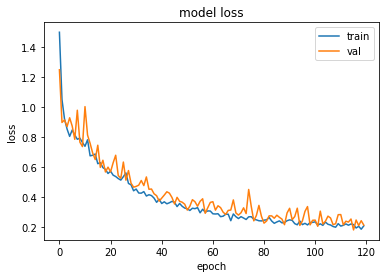

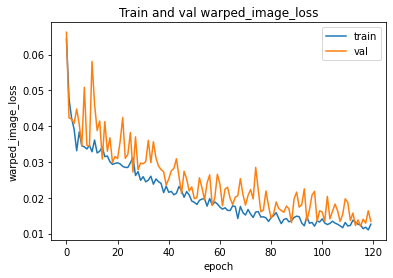

In [12]:
## model 5.3.5 DLIR_2_21param + LR_reduction + 10:1 coef
result_path = "checkpoints/DLIR_2_dataV3_21param/11_20_22-24-10/results.pkl"
with open(result_path, "rb") as f:
    history = pickle.load(f)
plot_loss(history, ylim=None, val_freq=1, start_epoch=0)
plot_accuracy(history, metric_name="warped_image_loss", val_freq=1, start_epoch=0)

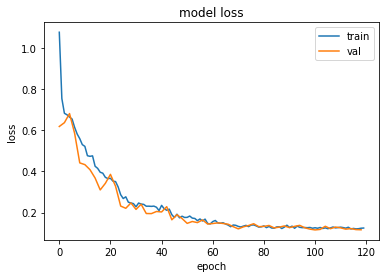

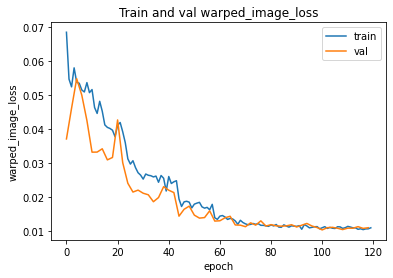

In [ ]:
## model 5.3.4 DLIR_2_21param + LR_reduction
history = results.history
plot_loss(history, ylim=None, val_freq=2, start_epoch=0)
plot_accuracy(history, metric_name="warped_image_loss", val_freq=2, start_epoch=0)

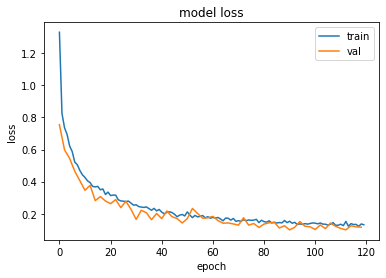

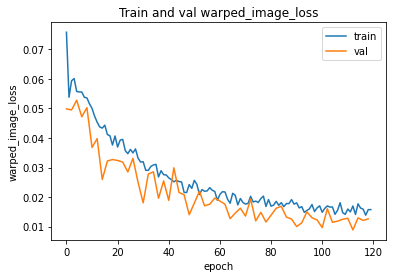

In [ ]:
## model 5.3.2  DLIR_2_21param: 
result_path = "checkpoints/DLIR_2_dataV3_21param/11_10_01-01-12/results.pkl"
with open(result_path, "rb") as f:
    history = pickle.load(f)

# history = results.history
plot_loss(history, ylim=None, val_freq=2, start_epoch=0)
plot_accuracy(history, metric_name="warped_image_loss", val_freq=2, start_epoch=0)

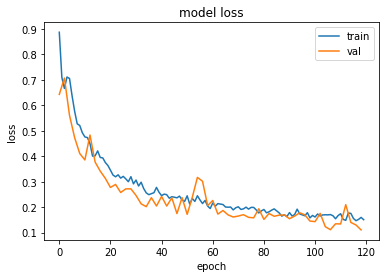

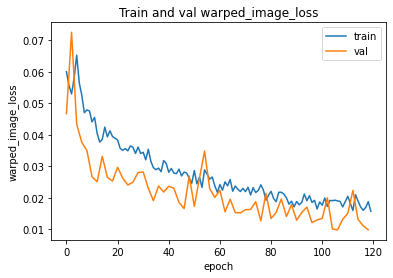

In [ ]:
## model 5.3  DLIR_2_21param
history = results.history
plot_loss(history, ylim=None, val_freq=2, start_epoch=0)
plot_accuracy(history, metric_name="warped_image_loss", val_freq=2, start_epoch=0)

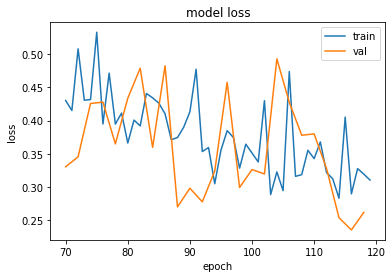

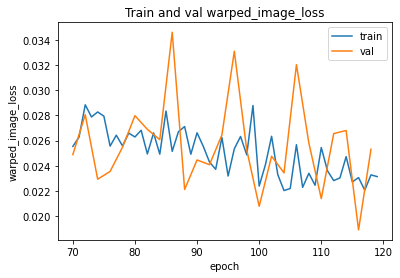

In [ ]:
## model 5.2 baseline DLIR 2
history = results.history
plot_loss(history, ylim=None, val_freq=2, start_epoch=70)
plot_accuracy(history, metric_name="warped_image_loss", val_freq=2, start_epoch=70)

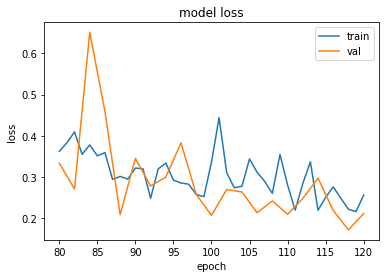

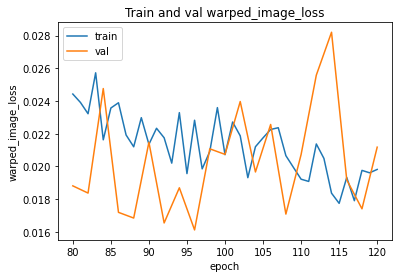

In [ ]:
## model 5.1 DLIR 2 v2
history = results.history
plot_loss(history, ylim=None, val_freq=2, start_epoch=80)
plot_accuracy(history, metric_name="warped_image_loss", val_freq=2, start_epoch=80)

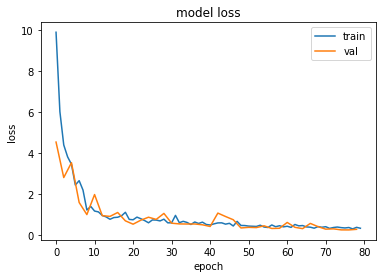

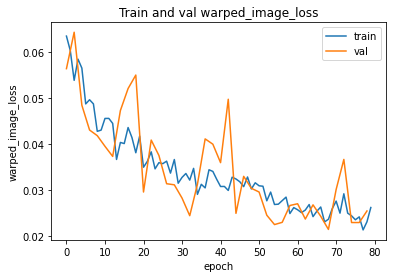

In [ ]:
## model 5.1 DLIR 2 v2
history = results.history
plot_loss(history, ylim=None, val_freq=2)
plot_accuracy(history, metric_name="warped_image_loss", val_freq=2)

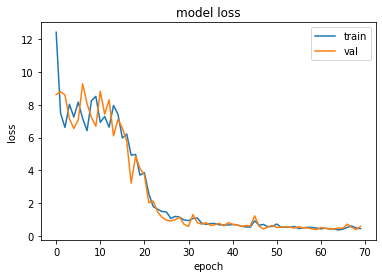

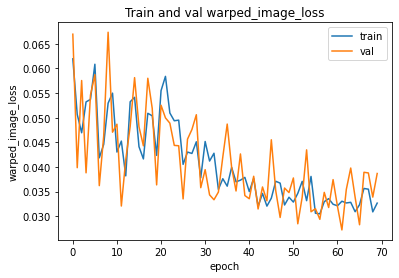

In [ ]:
## model 4.5.3 DLIR
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_loss")

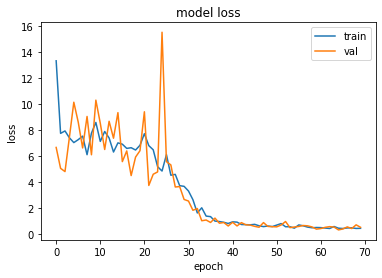

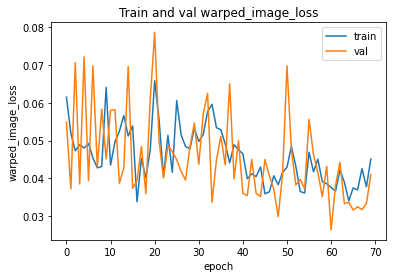

In [ ]:
## model 4.5.2 DLIR
# result_path = "checkpoints/DLIR_2/10_13_11-48-33/results.pkl"
# with open(result_path, "rb") as f:
#     history = pickle.load(f)

# plot_loss(history, ylim=None)
# plot_accuracy(history, metric_name="warped_image_loss")
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_loss")

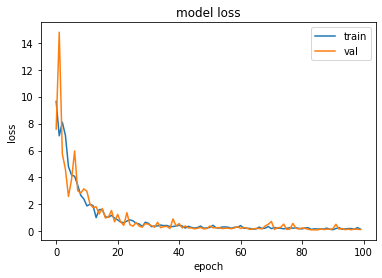

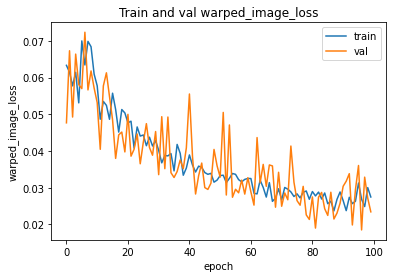

In [ ]:
## model 4.4.2 DLIR 2
plot_loss(results.history, ylim=None)
plot_accuracy(results.history, metric_name="warped_image_loss")

## Test model (output == warpedImg)

In [ ]:
# testModel = model
# np.set_printoptions(suppress=True, precision=4)

In [ ]:
### load weight
# dataGen = data_generator()
# testModel = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred])
# testModel.load_weights('./checkpoints/08_15_07-38-34/40.h5')

### load entire model
dataGen = data_generator(batchSize=4)
# testModel = keras.models.load_model('./checkpoints/baseline/10_12_11-17-17/47.h5', custom_objects=
#             {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
#              "affine_rep2param":affine_rep2param})
testModel = keras.models.load_model('./checkpoints/baseline/10_12_11-17-17/47.h5', custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
            })

Instructions for updating:
Use fn_output_signature instead


In [28]:
def evaluate_model(testModel, dataGen, num=20):
    """
    Evaluate the affine param difference and image mse.
    """
    scores = []
    mses = []
    for _ in tqdm(range(num)):
        moving_test, label_test = next(dataGen)
        gt_trf = label_test[1].numpy()
        warped_test, affine_pred_test = testModel(moving_test, training=False) # inference mode
        diff = np.abs(gt_trf - affine_pred_test.numpy())
        scores.append(diff)
        mse = ((warped_test[:,..., 0].numpy() - moving_test[:,..., 1].numpy())**2).mean()
        mses.append(mse)
    scores = np.mean(scores, axis=0) # mean of samples
    mses = np.mean(mses)
    if len(scores.shape) >=2:
        scores = np.mean(scores, axis=0) # mean of batches
    return{
#        "trans": scores[0:3].mean(),
#        "rot": scores[3:12].mean(),
#        "scale": scores[12:15].mean(),
#        "shear": scores[15:18].mean(),
        "tsf_param_mse": scores.mean(),
        "img_mse": mses,
    }

def plot_single_3D_image(path, testModel, gt_trf_key="trf", slice_to_begin=20, slice_num_show=10, slice_interval=2, compare_trf=False):
    """
    Visualize a single 3D scan image.
    """
    inputObj = np.load(path)
    fixed_img = inputObj["fixedImg"].astype("float32")
    movingImg = inputObj["movingImg"].astype("float32")
    gt_trf = inputObj[gt_trf_key].astype("float32")
    moving_test = np.concatenate([movingImg, fixed_img], axis=4)

    (warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode
    warped_test = warped_test.numpy()

    mse = ((fixed_img - warped_test)**2).mean()
    print("Sample: ", path)
    print("Sample mse:", mse)
    print((f" --- Sample {os.path.basename(path)}, slice {slice_to_begin} ~ {slice_to_begin}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show, 3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        axes[j,0].imshow(fixed_img[0,slice_to_begin + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[0,slice_to_begin + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[0,slice_to_begin + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()

    if compare_trf:
        np.set_printoptions(suppress=True, precision=4)
        print(gt_trf.round(3).reshape(-1))
        print("------------------")
        print(affine_pred_test.numpy().round(3).reshape(-1))
        print("------------------")

def plot_two_3D_image_as_fixed_and_moving(fixed_path, moving_path, testModel, gt_trf_key="trf", 
                                          slice_to_begin=20, slice_num_show=10, slice_interval=2, compare_trf=False):
    inputObj = np.load(fixed_path)
    fixed_img = inputObj["fixedImg"].astype("float32")
    inputObj = np.load(moving_path)
    movingImg = inputObj["movingImg"].astype("float32")
    gt_trf = inputObj[gt_trf_key].astype("float32")
    moving_test = np.concatenate([movingImg, fixed_img], axis=4)

    (warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode
    warped_test = warped_test.numpy()

    mse = ((fixed_img - warped_test)**2).mean()
    print("Sample: ", path)
    print("Sample mse:", mse)
    print((f" --- Sample {os.path.basename(path)}, slice {slice_to_begin} ~ {slice_to_begin}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show, 3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        axes[j,0].imshow(fixed_img[0,slice_to_begin + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(movingImg[0,slice_to_begin + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[0,slice_to_begin + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()

    if compare_trf:
        np.set_printoptions(suppress=True, precision=4)
        print(gt_trf.round(3).reshape(-1))
        print("------------------")
        print(affine_pred_test.numpy().round(3).reshape(-1))
        print("------------------")


In [20]:
testModel = keras.models.load_model("checkpoints/DLIR_2_dataV3_21param/11_22_02-52-40/06.h5", custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
             "affine_rep2param":affine_rep2param,
            })

Sample:  ./data/affineTrainingData3/test/affine_0_2.npz
Sample mse: 0.027401917
 --- Sample affine_0_2.npz, slice 20 ~ 20+2*10


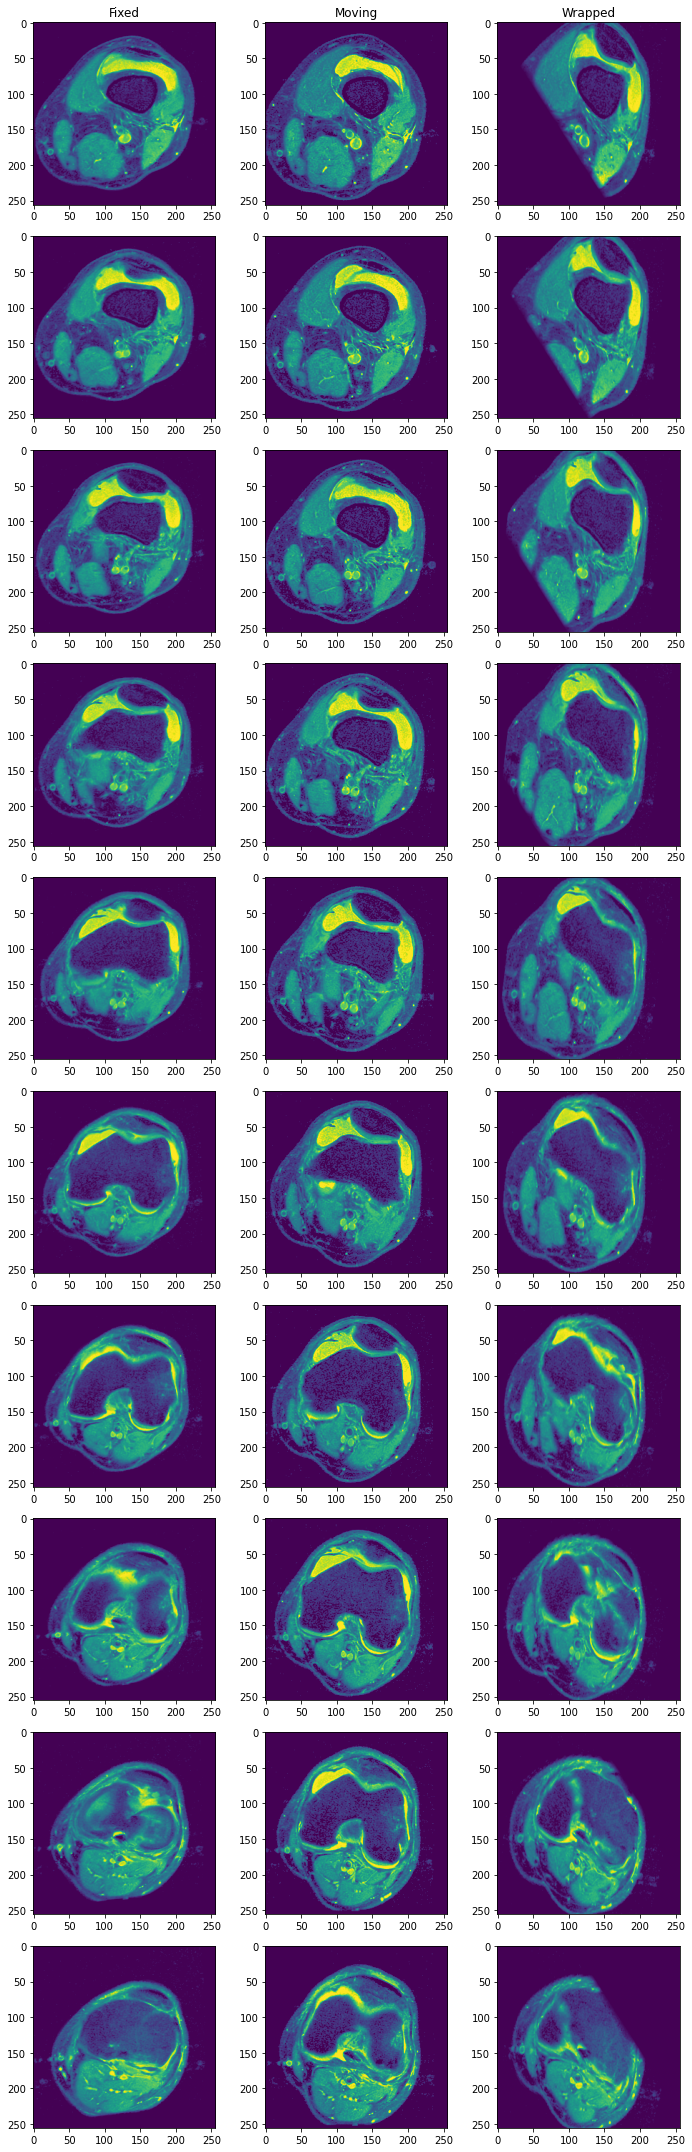

[ 4.877  2.744  0.     0.999 -0.033 -0.028  0.037  0.988  0.15   0.022
 -0.151  0.988  0.     0.002  0.034  0.002  0.012  0.041  1.069  1.148
  1.11 ]
------------------
[ 2.712  8.01   0.013  0.954 -0.09   0.162  0.224  1.003 -0.031 -0.241
 -0.105  1.036 -0.018  0.128 -0.013  0.242 -0.093 -0.114  1.224  0.84
  1.054]
------------------


In [29]:
path1 = test_path_list[0]
path2 = test_path_list[1]
plot_two_3D_image_as_fixed_and_moving(path1, path2, testModel, gt_trf_key="trf_21param", 
                     slice_to_begin=20, slice_num_show=10, slice_interval=2, compare_trf=True)

In [26]:
path = test_path_list[0]
plot_single_3D_image(path, testModel, gt_trf_key="trf_21param", 
                     slice_to_begin=20, slice_num_show=10, slice_interval=2, compare_trf=True)
path = test_path_list[1]
plot_single_3D_image(path, testModel, gt_trf_key="trf_21param", 
                     slice_to_begin=20, slice_num_show=10, slice_interval=2, compare_trf=True)

Output hidden; open in https://colab.research.google.com to view.

#### Result for model 10 DLIR_2_21param

##### T5
* E

* output_dir: checkpoints/DLIR_2_dataV3_21param/11_22_03-31-21
* 43642s = 12.1h

* change:
 * LR_reduction
 * T1 with new layer implementation
* 150 batchs, batch size=2, 120 epochs
* best val mse= 0.0121 at 116 epochs, test mse = 0.01

In [ ]:
## model 5.3.5 DLIR_2_21param + LR_reduction + 10:1 coef
result_path = "checkpoints/DLIR_2_dataV3_21param/11_22_03-31-21/results.pkl"
with open(result_path, "rb") as f:
    history = pickle.load(f)
plot_loss(history, ylim=None, val_freq=1, start_epoch=0)
plot_accuracy(history, metric_name="warped_image_loss", val_freq=1, start_epoch=0)

##### T4
* Epoch 116/120
150/150 [==============================] - 363s 2s/step - loss: 0.2194 - warped_image_loss: 0.0124 - affine_pred_rep_loss: 0.0952 - val_loss: 0.1839 - val_warped_image_loss: 0.0121 - val_affine_pred_rep_loss: 0.0631 - lr: 1.0000e-04

* output_dir: checkpoints/DLIR_2_dataV3_21param/11_20_22-24-10 
* 43642s = 12.1h

* change:
 * LR_reduction
 * 10:1 coef
* 150 batchs, batch size=2, 120 epochs
* best val mse= 0.0121 at 116 epochs, test mse = 0.013


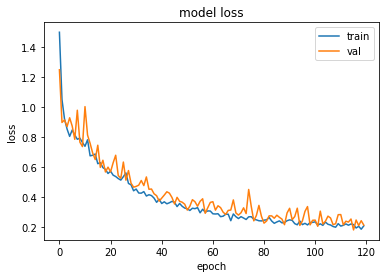

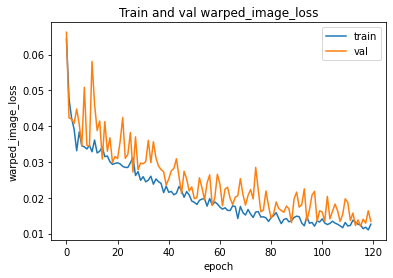

In [13]:
## model 5.3.5 DLIR_2_21param + LR_reduction + 10:1 coef
result_path = "checkpoints/DLIR_2_dataV3_21param/11_20_22-24-10/results.pkl"
with open(result_path, "rb") as f:
    history = pickle.load(f)
plot_loss(history, ylim=None, val_freq=1, start_epoch=0)
plot_accuracy(history, metric_name="warped_image_loss", val_freq=1, start_epoch=0)

In [18]:
testModel = keras.models.load_model("checkpoints/DLIR_2_dataV3_21param/11_20_22-24-10/116.h5", custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
             "affine_rep2param":affine_rep2param,
            })
steps = test_size//batch_size
testModel.evaluate(x=test_dataset, steps=steps, return_dict=True)

151/300 [==============>...............] - ETA: 5:43 - loss: 0.2183 - warped_image_loss: 0.0141 - affine_pred_rep_loss: 0.0771

KeyboardInterrupt: ignored

##### T3
* Epoch 116/120
150/150 [==============================] - 647s 4s/step - loss: 0.1492 - warped_image_loss: 0.0146 - affine_pred_rep_loss: 0.0907 - val_loss: 0.1184 - val_warped_image_loss: 0.0120 - val_affine_pred_rep_loss: 0.0703

* output_dir: checkpoints/DLIR_2_dataV3_21param/11_10_18-19-25 
* change the fourth maxPool layer of T1 to 2x2x2
* 150 batchs, batch size=2, 120 epochs
* best val mse= 0.0120 at 116 epochs
* 60100s

##### T2
* Epoch 92/120
150/150 [==============================] - 517s 3s/step - loss: 0.1408 - warped_image_loss: 0.0163 - affine_pred_rep_loss: 0.0754 - val_loss: 0.0992 - val_warped_image_loss: 0.0100 - val_affine_pred_rep_loss: 0.0590

* output_dir: checkpoints/DLIR_2_dataV3_21param/11_10_01-01-12 
* 5 (3x3x3 conv3d + 2x2x2 maxPool) + no global pooling
* 150 batchs, batch size=2, 120 epochs
* best val mse=0.01 at 92 epochs, test mse=0.01102
* 25493 = 7.5h

In [ ]:
testModel = keras.models.load_model("checkpoints/DLIR_2_dataV3_21param/11_10_01-01-12/92.h5", custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
             "affine_rep2param":affine_rep2param,
            })

In [ ]:
diff = evaluate_model(testModel, iter(test_dataset), num=(test_size//batch_size))
print("diff: ", diff)

  0%|          | 0/300 [00:00<?, ?it/s]

diff:  {'tsf_param_mse': 0.06724881, 'img_mse': 0.011018777}


In [ ]:
iterator = iter(msk_dataset(test_path_list, batch_size, gt_trf_key="trf_21param", train=True).get_dataset())
moving_test, label_test = next(iterator)
num_show = 2
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

fixed_img = label_test[0].numpy()
gt_trf = gt_trf.numpy()

sliceToCheck = 20
for i in range(num_show):
    mse = ((fixed_img[i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(fixed_img[i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
np.set_printoptions(suppress=True, precision=4)
print(gt_trf.round(3).reshape(-1))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

##### T1
* Epoch 120/120
150/150 [==============================] - 617s 4s/step - loss: 0.1506 - warped_image_loss: 0.0158 - affine_pred_rep_loss: 0.0875 - val_loss: 0.1105 - val_warped_image_loss: 0.0099 - val_affine_pred_rep_loss: 0.0709

* output_dir: checkpoints/DLIR_2_dataV3_21param/11_08_23-00-53 
* 150 batchs, batch size=2, 120 epochs
* best val mse=0.0099 at 120 epochs, test mse = 0.01031
* mse:rep loss = 4:1
* 48263s = 13.4h

In [ ]:
testModel = keras.models.load_model("checkpoints/DLIR_2_dataV3_21param/11_08_23-00-53/120.h5", custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
             "affine_rep2param":affine_rep2param,
            })

In [ ]:
testModel.evaluate(x=test_dataset, steps=2, return_dict=True)

ValueError: ignored

In [ ]:
diff = evaluate_model(testModel, iter(test_dataset), num=(test_size//batch_size))
print("diff: ", diff)

  0%|          | 0/300 [00:00<?, ?it/s]

diff:  {'tsf_param_mse': 0.07434806, 'img_mse': 0.010305897}


In [ ]:
iterator = iter(msk_dataset(test_path_list, batch_size, gt_trf_key="trf_21param", train=True).get_dataset())
moving_test, label_test = next(iterator)
num_show = 2
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

fixed_img = label_test[0].numpy()
gt_trf = gt_trf.numpy()

sliceToCheck = 20
for i in range(num_show):
    mse = ((fixed_img[i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(fixed_img[i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
np.set_printoptions(suppress=True, precision=4)
print(gt_trf.round(3).reshape(-1))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

#### Result for model 9 baseline_DLIR DataV3

##### T1
* Epoch 118/120, 150/150 - 548s 4s/step - loss: 0.3278 - warped_image_loss: 0.0221 - affine_pred_loss: 0.2396 - val_loss: 0.2357 - val_warped_image_loss: 0.0189 - val_affine_pred_loss: 0.1600
* 150 batchs, batch size=2, 120 epochs
* best val mse=0.0189

In [ ]:
testModel = keras.models.load_model("checkpoints/baseline_DLIR_dataV3/10_28_06-24-24/118.h5", custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
            })

In [ ]:
moving_test, label_test = next(iter(test_dataset))
num_show = 2
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

fixed_img = label_test[0].numpy()
gt_trf = gt_trf.numpy()

sliceToCheck = 20
for i in range(num_show):
    mse = ((fixed_img[i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(fixed_img[i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
np.set_printoptions(suppress=True, precision=4)
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
testModel.evaluate(x=test_dataset, steps=(test_size//batch_size), return_dict=True)

300/300 [==============================] - 853s 3s/step - loss: 0.2615 - warped_image_loss: 0.0193 - affine_pred_loss: 0.1841


{'affine_pred_loss': 0.1840917319059372,
 'loss': 0.26148855686187744,
 'warped_image_loss': 0.01934920810163021}

#### Result for model 8 DLIR 2 DataV3

##### T2
* (78: 150/150 - 587s 4s/step - loss: 0.3137 - warped_image_loss: 0.0214 - affine_pred_loss: 0.2281 - val_loss: 0.2633 - val_warped_image_loss: 0.0230 - val_affine_pred_loss: 0.1713)

* Epoch 118/120
150/150 - 616s 4s/step - loss: 0.2213 - warped_image_loss: 0.0198 - affine_pred_loss: 0.1423 - val_loss: 0.1711 - val_warped_image_loss: 0.0174 - val_affine_pred_loss: 0.1014
* 150 batchs, batch size=2, 120 epochs, best val mse=0.0174
* ~ 14h



In [ ]:
# testModel = model
testModel = keras.models.load_model("checkpoints/DLIR_2_dataV3/10_27_15-16-57/118.h5", custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
            })

In [ ]:
moving_test, label_test = next(iter(test_dataset))
num_show = 2
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

fixed_img = label_test[0].numpy()
gt_trf = gt_trf.numpy()

sliceToCheck = 20
for i in range(num_show):
    mse = ((fixed_img[i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(fixed_img[i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
np.set_printoptions(suppress=True, precision=4)
for i in gt_trf.round(3).reshape(-1,3,4):
    display(i)
for i in affine_pred_test.numpy().round(3).reshape(-1,3,4):
    display(i)
testModel.evaluate(x=test_dataset, steps=(test_size/batch_size), return_dict=True)

array([[ 0.899, -0.013,  0.001,  0.87 ],
       [ 0.053,  1.07 ,  0.037, 24.304],
       [ 0.035, -0.026,  0.899,  0.   ]], dtype=float32)

array([[ 1.119, -0.01 , -0.016,  1.83 ],
       [ 0.079,  1.136,  0.106, 27.628],
       [ 0.089, -0.048,  1.105,  0.   ]], dtype=float32)

array([[ 1.094,  0.008,  0.032,  1.761],
       [-0.021,  1.019,  0.13 , 27.518],
       [-0.005, -0.122,  0.962,  0.002]], dtype=float32)

array([[ 1.149, -0.   ,  0.035,  2.037],
       [ 0.089,  1.103,  0.17 , 29.948],
       [-0.027, -0.127,  1.037, -0.043]], dtype=float32)

300/300 [==============================] - 529s 2s/step - loss: 0.2312 - warped_image_loss: 0.0186 - affine_pred_loss: 0.1566


{'affine_pred_loss': 0.15657447278499603,
 'loss': 0.23115907609462738,
 'warped_image_loss': 0.01864616759121418}

In [ ]:
# compare with matlab
test_dataset_iter = iter(test_dataset)
for _ in range(5):
    tic = time.time()
    moving_test, label_test = next(test_dataset_iter)
    num_show = 1
    slice_num_show = 10 # >1
    slice_interval = 2
    moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
    (warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode
    toc = time.time()

    fixed_img = label_test[0].numpy()
    gt_trf = gt_trf.numpy()

    sliceToCheck = 20
    for i in range(num_show):
        mse = ((fixed_img[i] - warped_test[i].numpy())**2).mean()
        print("Sample mse:", mse)
        print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

        fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
        for j in range(slice_num_show):
            # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
            axes[j,0].imshow(fixed_img[i,sliceToCheck + j * slice_interval,:,:,0]) # F
            axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
            axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
        axes[0,0].set_title("Fixed")
        axes[0,1].set_title("Moving")
        axes[0,2].set_title("Wrapped")
        plt.tight_layout()
        plt.show()
        print("------------------")

    # print(["{:f.3}".format(x) for x in gt_trf])
    print(gt_trf.round(3).reshape(-1,3,4))
    print("------------------")
    print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
    print("------------------")
    print("time:", toc-tic)
    print("------------------")

Output hidden; open in https://colab.research.google.com to view.

##### T1
* 150/150 -514s 3s/step - loss: 0.4680 - warped_image_loss: 0.0261 - affine_pred_loss: 0.3635 - val_loss: 0.3507 - val_warped_image_loss: 0.0246 - val_affine_pred_loss: 0.2523
* 58 epoch, 150 batch, 2bs 50 val size 
* depth: [32, 64, 128, 512, 1024]

In [ ]:
testModel = keras.models.load_model("checkpoints/DLIR_2_dataV3/10_26_13-21-43/58.h5", custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
            })
test_dataset = msk_dataset(test_path_list, 1).get_dataset()

(TensorSpec(shape=(None, 64, 256, 256, 2), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 64, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)))


In [ ]:
moving_test, label_test = next(iter(test_dataset))
moving_test.numpy().shape

(2, 64, 256, 256, 2)

Sample mse: 0.017323745
  Sample 0, slice 20 ~ 20+2*10


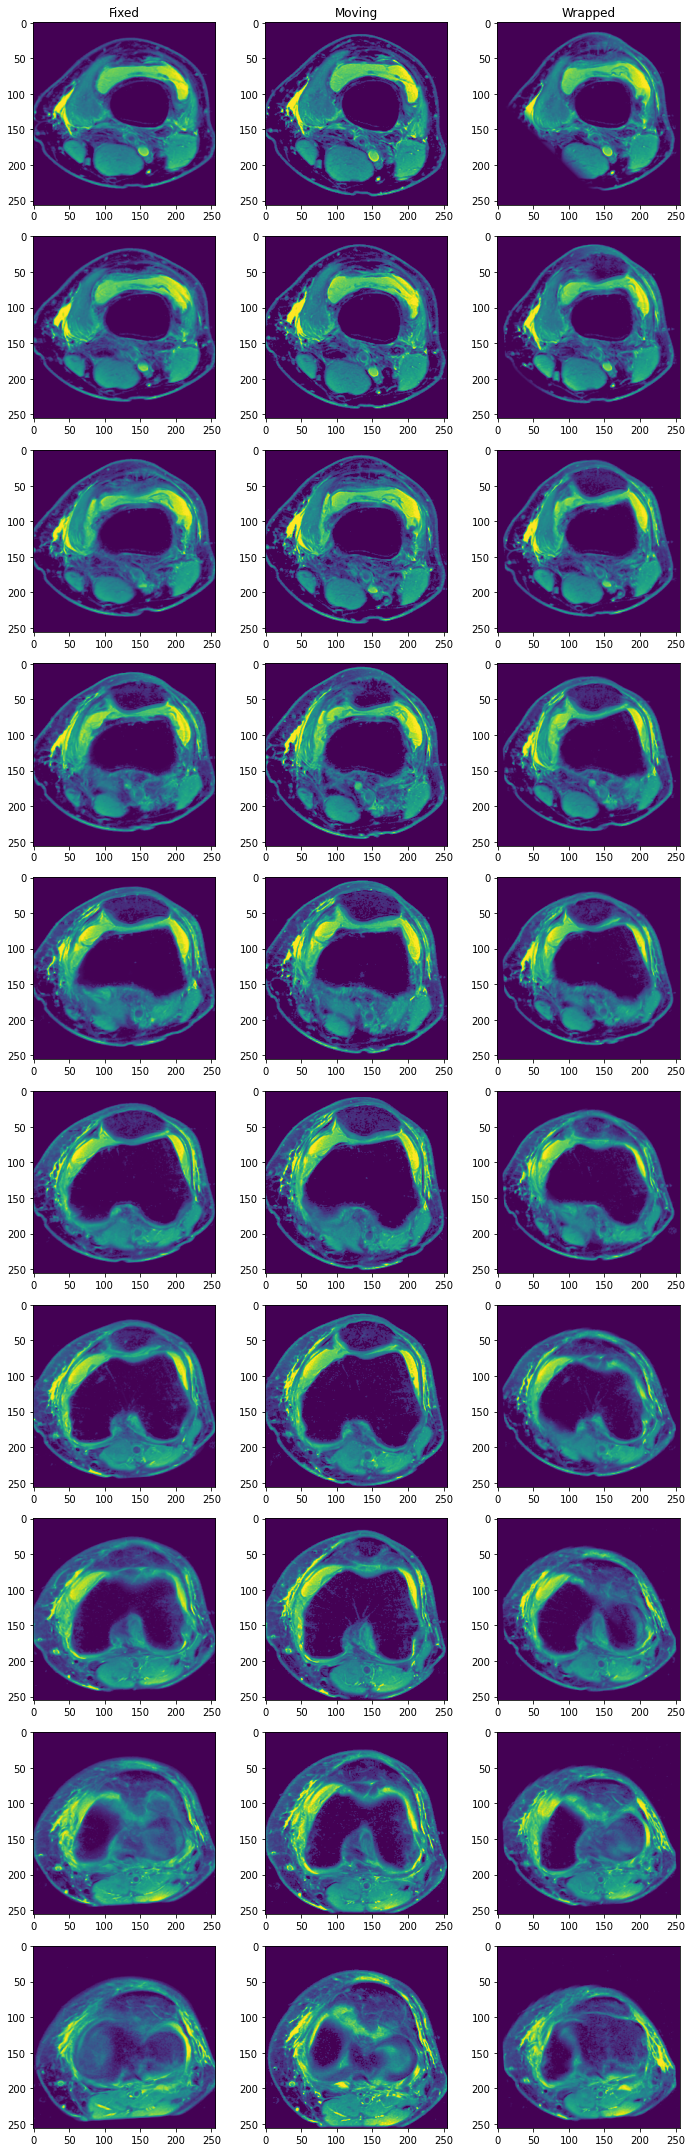

------------------
[[[ 1.057e+00 -2.000e-03  1.000e-03  1.140e+00]
  [ 5.000e-02  1.083e+00  6.500e-02  1.807e+00]
  [ 7.900e-02 -2.000e-02  9.770e-01  0.000e+00]]]
------------------
[[[ 1.057 -0.036  0.035  1.421]
  [ 0.071  1.073  0.087  0.888]
  [ 0.108 -0.056  1.061  0.02 ]]]
------------------


In [ ]:
moving_test, label_test = next(iter(test_dataset))
num_show = 1
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode
fixed_img = label_test[0].numpy()
gt_trf = gt_trf.numpy()

sliceToCheck = 20
for i in range(num_show):
    mse = ((fixed_img[i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(fixed_img[i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

In [ ]:
tic2-tic1, tic3-tic2

(1.6638357639312744, 0.7981102466583252)

#### Result for model 7 DLIR
* 40/40 - 171s 4s/step - loss: 0.3466 - warped_image_loss: 0.0386 - affine_pred_loss: 0.3080 - val_loss: 0.3648 - val_warped_image_loss: 0.0451 - val_affine_pred_loss: 0.3197
* lr = 0.0001 (converged)
* one pipeline processes each image separately
* depth: [16, 64, 128, 512, 1024]

----

* 40/40 - 158s 4s/step - loss: 0.4280 - warped_image_loss: 0.0340 - affine_pred_loss: 0.3940 - val_loss: 0.2957 - val_warped_image_loss: 0.0336 - val_affine_pred_loss: 0.2620
* lr = 0.00005, epoch=70


In [ ]:
# testModel = model
dataGen = data_generator(batchSize=4)
testModel = keras.models.load_model("checkpoints/DLIR/10_14_03-44-18/65.h5", custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
            })

In [ ]:
"""
40/40 - 171s 4s/step - loss: 0.3466 - warped_image_loss: 0.0386 - affine_pred_loss: 0.3080 - val_loss: 0.3648 - val_warped_image_loss: 0.0451 - val_affine_pred_loss: 0.3197
lr = 0.0001 (converged)
one pipeline processes each image separately
depth: [16, 64, 128, 512, 1024]
"""
moving_test, label_test = next(dataGen)
num_show = 4
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

#### Result for model 6 DLIR 2

* 80/80 - 188s 2s/step - loss: 0.1700 - warped_image_loss: 0.0256 - affine_pred_loss: 0.1187 - val_loss: 0.1090 - val_warped_image_loss: 0.0225 - val_affine_pred_loss: 0.0641
* lr = 0.0001 (converged), 100 epoch, 2 bs, 80 ierations, 2:1 loss weight
* one pipeline processes both image together

In [ ]:
dataGen = data_generator(batchSize=2)
testModel = model

In [ ]:
moving_test, label_test = next(dataGen)
num_show = 2
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
moving_test, label_test = next(dataGen)
num_show = 2
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

* 40/40 - 168s 4s/step - loss: 0.2386 - warped_image_loss: 0.0324 - affine_pred_loss: 0.2062 - val_loss: 0.2132 - val_warped_image_loss: 0.0246 - val_affine_pred_loss: 0.1886
* lr = 0.001 
* one pipeline processes both image together

In [ ]:
dataGen = data_generator(batchSize=4)
testModel = keras.models.load_model("checkpoints/DLIR_2/10_13_11-48-33/47.h5", custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
            })
# testModel = keras.models.load_model("checkpoints/baseline_DLIR/10_13_05-22-00/50.h5", custom_objects=
#             {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
#             })

Instructions for updating:
Use fn_output_signature instead


In [ ]:
moving_test, label_test = next(dataGen)
num_show = 4
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

#### Result for model 5 baseline_DLIR
* Epoch 100/100, 80/80  - 200s 3s/step - loss: 0.2332 - warped_image_loss: 0.0259 - affine_pred_loss: 0.1039 - val_loss: 0.2456 - val_warped_image_loss: 0.0218 - val_affine_pred_loss: 0.1365
* lr = 0.0001 (converged), 100 epoch, 2 bs, 80 ierations, 4:1 loss weight
* add lr scheduler


In [ ]:
dataGen = data_generator(batchSize=2)
testModel = model

In [ ]:
moving_test, label_test = next(dataGen)
num_show = 2
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
moving_test, label_test = next(dataGen)
num_show = 2
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.


* 2 pipeline + DLIR convNet structure
* bs = 4, 40 batch, 50 epoch
* 40/40 - 149s 4s/step - loss: 0.4286 - warped_image_loss: 0.0351 - affine_pred_loss: 0.3935 - val_loss: 0.3038 - val_warped_image_loss: 0.0282 - val_affine_pred_loss: 0.2756
* 8000 samples aren't enough, can still improve


In [ ]:
dataGen = data_generator(batchSize=4)
testModel = keras.models.load_model("checkpoints/baseline_DLIR/10_13_05-22-00/48.h5", custom_objects=
            {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
            })
# testModel = keras.models.load_model("checkpoints/baseline_DLIR/10_13_05-22-00/50.h5", custom_objects=
#             {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
#             })

In [ ]:
moving_test, label_test = next(dataGen)
num_show = 4
slice_num_show = 10 # >1
slice_interval = 2
moving_test, gt_trf = moving_test[:num_show], label_test[1][:num_show]
(warped_test, affine_pred_test) = testModel(moving_test, training=False) # inference mode

sliceToCheck = 20
for i in range(num_show):
    mse = ((label_test[0][i] - warped_test[i].numpy())**2).mean()
    print("Sample mse:", mse)
    print((f"  Sample {i}, slice {sliceToCheck} ~ {sliceToCheck}+{slice_interval}*{slice_num_show}"))

    fig, axes = plt.subplots(slice_num_show,3, figsize=(10,3*slice_num_show))
    for j in range(slice_num_show):
        # axes[j,1].imshow(fixedImg[0,sliceToCheck + j * slice_interval,...,0])   # M
        axes[j,0].imshow(label_test[0][i,sliceToCheck + j * slice_interval,:,:,0]) # F
        axes[j,1].imshow(moving_test[i,sliceToCheck + j * slice_interval,:,:,0])   # M
        axes[j,2].imshow(warped_test[i,sliceToCheck + j * slice_interval,:,:,0])
    axes[0,0].set_title("Fixed")
    axes[0,1].set_title("Moving")
    axes[0,2].set_title("Wrapped")
    plt.tight_layout()
    plt.show()
    print("------------------")

# print(["{:f.3}".format(x) for x in gt_trf])
print(gt_trf.round(3).reshape(-1,3,4))
print("------------------")
print(affine_pred_test.numpy().round(3).reshape(-1,3,4))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.